In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

#  **1. Read or generate binary data**
---

## &emsp; -> <span style='color:white'>mis<span style='color:white'>

### &emsp; * <span style='color:white'>import<span style='color:white'>

In [1]:
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Label, Button
from ipywidgets import IntSlider
from ipywidgets import interact

import numpy as np 
import pandas as pd

from os import listdir
from os.path import isfile, join

import random
import math

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda 
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

### &emsp; * <span style='color:white'>class<span style='color:white'>

In [2]:
class Originl_Data:
    # 建構式
    def __init__(self,shp_name):
        df_read = pd.read_csv(rf"C:\Users\User\Desktop\Terry\Data\Output\oval shape data\{shp_name}.csv", index_col=0,)
        # df_read = df_read.drop(["index"], axis = 1)
        self.df_read = df_read.copy()
        
    # 方法(Method)
    def slice_to_bin(self, bc):
        df = self.df_read.iloc[:,:-1]
        gap, n_feat, new_data = [0],0,[]
        label_encoder = LabelEncoder()
        # finding slicing gap
        for c in df.columns:
            mx,mn = int(max(df[c]))+1,int(min(df[c]))-1
            n_bins =  int(bc/3)
            n_feat = n_feat+n_bins
            gap.append(n_feat)
            y = label_encoder.fit_transform(pd.cut(df[c], n_bins, retbins=True)[0])
            new_data.append(list(y))
        df_new = pd.DataFrame(new_data)

        # changing data gird in to binary
        df = df_new.T
        new_data = []
        for r in df.values:
            l_1 = []
            nr_data = []
            for i in range(0,len(gap)-1):      
                l_1.append( gap[i]+r[i])
            for i in range(0,gap[-1]): 
                if i in l_1:
                    nr_data.append(1)
                else:
                    nr_data.append(0)
            new_data.append(nr_data)
        new_data

        # adding feature name
        n_f_name = []
        cur = 0
        s = 96
        for i in range(0,gap[-1]):
            if i >= gap[cur]:
                cur = cur + 1
                s = s+1
            n_f_name.append(f"{chr(s)}-{i-gap[cur-1]+1}")

        # generating new binary data
        df_new = pd.DataFrame(new_data)
        df_new.columns = n_f_name
        df_new['GB'] = self.df_read.iloc[:,-1:]
        self.df_bin = df_new      
        # self.df_bin = slice_cont_to_bin(self.df_read.copy(), bc)
        self.bin_feat = len(self.df_bin.columns[:-1])
        
    def drop_one_col_rnd(self, ):
        cols, col_list = self.df_bin.columns, [i for i in range(0,len(self.df_bin.columns))]
        ax, l_drop = int(len(self.df_bin.columns[:-1])/3),[]
        for i in range(0,3):l_drop.append(i*ax+random.randint(0,ax-1))
        self.df_bin = self.df_bin.iloc[:,[col for col in col_list if col not in l_drop]]
        self.bin_feat = len(self.df_bin.columns[:-1])
        return [cols[col] for col in  l_drop]
    
    def drop_one_col_minsum(self, ):
        self.get_sep_and_col()
        cols, df, sep = self.df_bin.columns, self.df_bin.copy(), self.sep
        l_sum,l_drop=[sum(self.df_bin[c]) for c in cols[:-1]],[]
        for i,s in enumerate( sep[:-1]):
            l = l_sum[s:sep[i+1]]
            l_drop.append(l.index(min(l))+s)
            # print(l.index(min(l)),s,l.index(min(l))+s)
        l_drop = cols[l_drop]
        self.df_bin = df[[c for c in df if c not in l_drop]]
        self.bin_feat = len(self.df_bin.columns[:-1])
        self.get_sep_and_col()
        return l_drop
    
    def drop_zero_col(self,):
        zero_col=[c for c in self.df_bin.columns[:-1] if sum(list(self.df_bin[c])) == 0]
        self.df_bin = self.df_bin.drop( columns=zero_col)
        self.bin_feat = len(self.df_bin.columns[:-1])
        return zero_col
    
    def get_sep_and_col(self,):
        col = self.df_bin.copy().columns[:-1]
        pre_c = col[0].split('-')[0]

        sep, col_name= [0],[pre_c]
        for i in range(0,len(col)):
            new_c = col[i].split('-')[0]
            if pre_c != new_c:
                sep.append(i)
                col_name.append(new_c)
            pre_c = new_c
        sep.append(len(col))
        self.n_group = len(sep) -1
        self.sep = sep
        self.col_name = col_name
        return sep, col_name
    
    def spilt_train_and_test(self, ratio):
        X,y = self.df_bin.iloc[:,:-1],self.df_bin.iloc[:,-1:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = ratio,stratify=y)
        X_train[y_train.columns[0]] = y_train
        X_test[y_test.columns[0]] = y_test
        self.df_train = X_train
        self.df_test = X_test
        
    def spilt_SKFold(self, split):
        kf = StratifiedKFold(n_splits = split, shuffle = True)
        X,y = self.df_bin.iloc[:,:-1],self.df_bin.iloc[:,-1:]
        results = list(kf.split(X,y))
        self.kFolds = results
        
    def set_folds(self, fold_num):
        fold = self.kFolds[fold_num]
        self.df_train = self.df_bin.iloc[fold[0]]
        self.df_test =  self.df_bin.iloc[fold[1]]

## <span style='color:lightblue'>read cont. data from path<span style='color:lightblue'>

### &emsp;| (1) read in csv

In [3]:
path  = r"C:\Users\User\Desktop\Terry\Data\Output\oval shape data"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
def get_df_path(sender):
    global df_select
    df_select = rb_df.value
rb_df = widgets.RadioButtons(
    options=onlyfiles,
    layout={'width': 'max-content'},
)
df_select = onlyfiles[0]
rb_df.observe(get_df_path)
rb_df

RadioButtons(layout=Layout(width='max-content'), options=('shape 1.csv', 'shape 2.csv', 'shape 3.csv', 'shape …

In [4]:
shp_name = "shape 1"
ori_data = Originl_Data(shp_name)

In [7]:
fig = go.Figure()
df = ori_data.df_read
df1 = df.loc[df[df.columns[-1]] == 1]
df0 = df.loc[df[df.columns[-1]] == 0]
GB_1 = go.Scatter3d(x=df1[df.columns[0]], y=df1[df.columns[1]], z=df1[df.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=1), showlegend=True, name = "GB_1")#,legendgroup=k,)
GB_0 = go.Scatter3d(x=df0[df.columns[0]], y=df0[df.columns[1]], z=df0[df.columns[2]],mode='markers', marker=dict(size=3, color = "blue", opacity=0.5), showlegend=True, name = "GB_0")#,legendgroup=k,)
fig.add_trace(GB_1)
fig.add_trace(GB_0)
fig_path = rf"C:\Users\User\Desktop\Terry\Data\Datasets\{shp_name}, 3D plot.html"
if os.path.exists(f"{fig_path}"): os.remove(f"{fig_path}")
with open(fig_path, 'a') as f:
    f.write(fig.to_html(full_html=True))

NameError: name 'os' is not defined

### &emsp;| (2) slicing to binary 

In [5]:
sd_sp = widgets.IntSlider(value = 3, min = 0, max = 150, step = 3,description='')
display(VBox([Button(description="slicing parts"), sd_sp]))

In [6]:
ori_data.slice_to_bin(sd_sp.value)

### &emsp;| (3) Check slice out empty

In [7]:
ori_data.drop_zero_col()

[]

### &emsp;| (4) drop one column on each axis

In [8]:
ori_data.drop_one_col_minsum()

Index(['a-1', 'b-1', 'c-1'], dtype='object')

### &emsp;| (5) split train and test

In [9]:
ori_data.get_sep_and_col()

([0, 25, 50, 75], ['a', 'b', 'c'])

In [10]:
ori_data.spilt_SKFold(4)

In [12]:
ori_data.set_folds(0)

In [14]:
# ori_data.spilt_train_and_test(0.75)

## <span style='color:brown'>generate cont. data<span style='color:brown'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

In [160]:
### df an plot
def generate_3_dim_df(x,y,z, tp):
    x_axis=[]
    y_axis=[]
    z_axis=[]
    the = []
    sca = []
    tps = []
    # data_type = []
    for i in range(0, x.shape[0]):
        x_axis.append(x[i])
        y_axis.append(y[i])
        z_axis.append(z[i])
        tps.append(tp)
    list_of_tuples = list(zip(x_axis, y_axis, z_axis,tps))
    df = pd.DataFrame(list_of_tuples,
                    columns = ['x', 'y', 'z','GB'])
    return df

def plot_3d_df(df):
    data = [go.Scatter3d(x=df[df.columns[0]], y=df[df.columns[1]], z=df[df.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=0.6), showlegend=True, name = "")]
    fig = go.Figure(data)
    # fig = go.Figure(data=data)
    fig.update_layout(title_text=" " , title_x=0.5)
    fig.update_layout( xaxis =  {'showgrid': False},yaxis = {'showgrid': True}, title_text=f'Scatter Plot <br><sup>{df_name}</sup> ',)
    
    # fig.show()
    return fig

def plot_3d_df_new(df):
    df1 = df.loc[df[df.columns[-1]] == 1]
    df0 = df.loc[df[df.columns[-1]] == 0]
    GB_1 = [go.Scatter3d(x=df1[df.columns[0]], y=df1[df.columns[1]], z=df1[df.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=0.6), showlegend=True, name = "GB_1")]
    GB_0 = [go.Scatter3d(x=df0[df.columns[0]], y=df0[df.columns[1]], z=df0[df.columns[2]],mode='markers', marker=dict(size=3, color = "blue", opacity=0.6), showlegend=True, name = "GB_0")]
    
    fig = go.Figure(GB_1 + GB_0)
    # fig = go.Figure(data=data)
    fig.update_layout(title_text=" " , title_x=0.5)
    fig.update_layout( xaxis =  {'showgrid': False},yaxis = {'showgrid': True}, title_text=f' Scatter Plot <br><sup>{df_name}</sup> ',)
    # fig.show()
    return fig

def plot_3d_df_UI(df1, df0 , w, h):
    GB_1 = [go.Scatter3d(x=df1[df1.columns[0]], y=df1[df1.columns[1]], z=df1[df1.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=0.6), showlegend=True, name = "GB_1")]
    GB_0 = [go.Scatter3d(x=df0[df0.columns[0]], y=df0[df0.columns[1]], z=df0[df0.columns[2]],mode='markers', marker=dict(size=3, color = df0.GB, colorscale='Bluered', opacity=0.6), showlegend=True, name = "GB_0")]
    fig = go.FigureWidget(GB_0 + GB_1)
    fig.update_layout(title_text=" " , title_x=0.5)
    fig.update_layout( xaxis =  {'showgrid': False},yaxis = {'showgrid': True}, title_text=f' Scatter Plot <br><sup>{df_name}</sup> ', width=w,height=h,)
    return fig

def plot_3d_df_all(df_read_data, df_new_data):
    df_read, df_new = df_read_data.copy(), df_new_data.copy()
    df_dict = {'Original cont.':df_read, 'encoded':df_new} 
    dict_key = list(df_dict.keys())
    
    fig = make_subplots(rows=1, cols=2,subplot_titles=(dict_key),specs=[[{'type': 'surface'}, {'type': 'surface'}]],)
    for k in range (0, len(dict_key)):  
        df = df_dict[dict_key[k]]
        df1 = df.loc[df[df.columns[-1]] == 1]
        df0 = df.loc[df[df.columns[-1]] == 0]
        GB_1 = go.Scatter3d(x=df1[df.columns[0]], y=df1[df.columns[1]], z=df1[df.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=1), showlegend=True, name = "GB_1")#,legendgroup=k,)
        GB_0 = go.Scatter3d(x=df0[df.columns[0]], y=df0[df.columns[1]], z=df0[df.columns[2]],mode='markers', marker=dict(size=3, color = "blue", opacity=0.5), showlegend=True, name = "GB_0")#,legendgroup=k,)
        # fig = go.Figure(GB_1 + GB_0)
        fig.add_trace(GB_1,row=1, col=k+1)
        fig.add_trace(GB_0,row=1, col=k+1)
        # fig.add_trace([GB_1 + GB_0],row=1, col=k+1)
    fig.update_layout(title_text=" " , title_x=0.5)
    fig.update_layout( xaxis =  {'showgrid': False},yaxis = {'showgrid': True}, title_text=f' Scatter Plot <br><sup>{df_name}</sup> ',)
    return fig

In [161]:
### UI
def rb_axis_selection(sender): 
    global axis, remain_axies
    axis = rb_axis.value
    sd_off.value = cur_off[num_df][axis]
    sd_str.value = cur_str[num_df][axis]
    sd_rot.value = cur_the[num_df][axis]
    
    remain_axies = []
    remain_axies = df.columns[:3].tolist()
    remain_axies.remove(axis)
    
def rb_dataframe_selection(sender): 
    global df, num_df
    tp = rb_group.value
    if tp == 'majority': 
        df = df_0
        num_df = 0
    elif tp == 'minority':
        df = df_1
        num_df = 1
    sd_off.value = cur_off[num_df][axis]
    sd_str.value = cur_str[num_df][axis]
    sd_rot.value = cur_the[num_df][axis]

def update_offset(offset):
    global cur_off
    with fig.batch_update():
        fig.data[num_df][axis] = fig.data[num_df][axis] + (offset['new'] - cur_off[num_df][axis])
        cur_off[num_df][axis] = offset['new']
        
def update_scale(stretch):
    global cur_str
    with fig.batch_update():
        fig.data[num_df][axis] = (fig.data[num_df][axis] - np.mean(fig.data[num_df][axis]))* (stretch['new']/cur_str[num_df][axis]) + np.mean(fig.data[num_df][axis])
        cur_str[num_df][axis] = stretch['new']
        
def update_rotate(rotate):
    global cur_the
    with fig.batch_update():    
        theta = (np.pi/180) * (rotate['new'] - cur_the[num_df][axis])
        rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                               [np.sin(theta), np.cos(theta)]])    
        x_old, y_old = fig.data[num_df][remain_axies[0]], fig.data[num_df][remain_axies[1]]
        x_new, y_new = rot_matrix @ [x_old - np.mean(x_old), y_old- np.mean(y_old)]
        fig.data[num_df][remain_axies[0]], fig.data[num_df][remain_axies[1]] = x_new+np.mean(x_old), y_new+np.mean(y_old)
        cur_the[num_df][axis] = rotate['new']



In [162]:
cur_the = [{'x':0, 'y':0,'z':0,},{'x':0, 'y':0,'z':0,}]
cur_off = [{'x':0, 'y':0,'z':0,},{'x':0, 'y':0,'z':0,}]
cur_str = [{'x':1, 'y':1,'z':1,},{'x':1, 'y':1,'z':1,}]
intval = 5
remain_axies = ['y','z']

rb_group = widgets.RadioButtons(
    options=['majority', 'minority'],
    layout={'width': 'max-content'},
)

rb_axis = widgets.RadioButtons(
    options=['x', 'y', 'z'],
    layout={'width': 'max-content'},
)

sd_off = widgets.FloatSlider(value = 0, min = -10, max = 10, step = 0.01, description='offest')
sd_str = widgets.FloatSlider(value = 1, min = 0.01, max = 5, step = 0.01, description='stretch')
sd_rot = widgets.FloatSlider(value = 0, min = 0, max = 360, step = 1,description='rotate')
vb_morph = VBox([Button(description="Morph"),sd_off,sd_str,sd_rot])


rb_group.observe(rb_dataframe_selection, names=['value'])
rb_axis.observe(rb_axis_selection, names=['value'])
        
sd_off.observe(update_offset, names='value')
sd_str.observe(update_scale, names='value')
sd_rot.observe(update_rotate, names='value')

In [163]:
def slice_cont_to_bin(df_read, sliced_part):
    df = df_read.iloc[:,:-1]
    new_data = []
    gap = [0]
    n_feat = 0
    label_encoder = LabelEncoder()
    # finding slicing gap
    for c in df.columns:
        mx = int(max(df[c]))+1
        mn = int(min(df[c]))-1
        n_bins = sliced_part
        n_feat = n_feat+n_bins
        gap.append(n_feat)
        y = label_encoder.fit_transform(pd.cut(df[c], n_bins, retbins=True)[0])
        new_data.append(list(y))
    df_new = pd.DataFrame(new_data)

    # changing data gird in to binary
    df = df_new.T
    new_data = []
    for r in df.values:
        l_1 = []
        nr_data = []
        for i in range(0,len(gap)-1):      
            l_1.append( gap[i]+r[i])
        for i in range(0,gap[-1]): 
            if i in l_1:
                nr_data.append(1)
            else:
                nr_data.append(0)
        new_data.append(nr_data)
    new_data

    # adding feature name
    n_f_name = []
    cur = 0
    s = 96
    for i in range(0,gap[-1]):
        if i >= gap[cur]:
            cur = cur + 1
            s = s+1
        n_f_name.append(f"{chr(s)}-{i-gap[cur-1]}")
        
    # generating new binary data
    df_new = pd.DataFrame(new_data)
    df_bin = df_new
    df_bin.columns = n_f_name
    df_bin['GB'] = df_read.iloc[:,-1:]
    return df_bin

### &emsp;| (1) df gnerate

In [164]:
# settings
# df_name = " "
num_of_pt = 3030
num_of_noise = 30
x_mu, x_sig = 0,0.5
y_mu, y_sig = 0,0.5
z_mu, z_sig = 0,0.5
x = np.random.normal(x_mu, x_sig, num_of_pt)
y = np.random.normal(y_mu, y_sig, num_of_pt)
z = np.random.normal(z_mu, z_sig, num_of_pt)

df_0 = generate_3_dim_df(x,y,z, 0)

In [165]:
# noise
random.seed(1224)
noise = random.choices(df_0.index, k=num_of_noise)
df_0.at[noise,"GB"] = 1
# print(noise)

In [166]:
num_of_pt = 270
x_mu, x_sig = 0,0.1
y_mu, y_sig = 0,0.1
z_mu, z_sig = 0,0.1
x = np.random.normal(x_mu, x_sig, num_of_pt)
y = np.random.normal(y_mu, y_sig, num_of_pt)
z = np.random.normal(z_mu, z_sig, num_of_pt)

df_1 = generate_3_dim_df(x,y,z, 1)

### &emsp;| (2) UI setting

In [167]:
df = df_0
num_df = 0
axis = 'x'    
shp_name = "shape 5"
df_name = f"Data generation / {shp_name} "
fig = plot_3d_df_UI(df_1,df_0 , 1200,600)

### &emsp;| (3) adjusting

In [168]:
left_box = VBox([Button(description="Group"), rb_group])
center_box = VBox([Button(description="Axis"), rb_axis])
right_box = vb_morph
display(HBox([left_box, center_box, vb_morph]))
fig

FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
                …

### &emsp;| (4) output df cont.

In [169]:
out_put_df = True

In [170]:
df_new_0 = pd.DataFrame()
df_new_0['x'] = fig.data[0].x.tolist()
df_new_0['y'] = fig.data[0].y.tolist()
df_new_0['z'] = fig.data[0].z.tolist()
df_new_0['GB'] = df_0.GB

df_new_1 = pd.DataFrame()
df_new_1['x'] = fig.data[1].x.tolist()
df_new_1['y'] = fig.data[1].y.tolist()
df_new_1['z'] = fig.data[1].z.tolist()
df_new_1['GB'] = df_1.GB

df_r = pd.concat([df_new_0,df_new_1],axis=0)
df_r.reset_index(inplace=True, drop=True)

path  = r"C:\Users\User\Desktop\Terry\Data\Output\oval shape data"
if out_put_df:
    df_r.to_csv(f"{path}/{shp_name}.csv")

### &emsp;| (5) slicing to binary 

In [139]:
sd_sp = widgets.IntSlider(value = 3, min = 0, max = 150, step = 3,description='')
VBox([Button(description="slicing parts"), sd_sp])

In [140]:
n_bin_col = sd_sp.value
df_b = slice_cont_to_bin(df_r, n_bin_col)
df_b.head()

a-0  b-0  c-0  GB
0    1    1    1   0
1    1    1    1   0
2    1    1    1   0
3    1    1    1   0
4    1    1    1   0

## <span style='color:DarkOliveGreen'>generate MLP data<span style='color:DarkOliveGreen'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

In [254]:
# fuzzy set pdf
def pdf_tri(l_x, peck, h):
    xp = l_x.index(peck)
    if xp == 0:climb = 0
    else:climb = h/xp
    desent = h/(len(l_x)-xp)
    y_out = []
    for i, x in enumerate(l_x):
        if x <= peck:
            y_out.append(climb*i)
        elif x > peck:
            y_out.append(h-desent*(i-xp))
    return y_out

def pdf_trap(l_x, p0,p1, h):
    xp0 = l_x.index(p0)
    xp1 = l_x.index(p1)
    if xp0 == 0:climb = 0
    else:climb = h/xp0
    
    desent = h/(len(l_x)-xp1)
    y_out = []
    for i, x in enumerate(l_x):
        if x <= p0:
            y_out.append(climb*i)
        elif p0 < x <= p1:
            y_out.append(h)
        elif p1 < x:
            y_out.append(h-desent*(i-xp1))
    return y_out

def cal_bins(step, range_x):
    fractional, whole = math.modf(step)
    round_to = len(str(fractional))-2
    
    bins = (range_x[1]-range_x[0])/step
    x = []
    for i in np.arange(range_x[0],range_x[1]+step,step):
        x.append(round(i, round_to))
    return x

def fuzzy_plot(gb1_xy, gb0_xy):
    gb_1 = go.Bar(x=gb1_xy[0], y=gb1_xy[1], name = "Bad (GB=1)",marker=dict(color =  "red", opacity=0.3))
    gb_0 = go.Bar(x=gb0_xy[0], y=gb0_xy[1], name = "Good (GB=0)",marker=dict(color = "blue", opacity=0.3))
    Data = [gb_1,gb_0]
    total_area = 0
    sum_y = []
    for i in np.arange(0,10+step, step):
        for t in Data:
            if i in t['x']:
                total_area = total_area + t['y'][t['x'].index(i)]
        sum_y.append(total_area)

    cum = go.Scatter(x=[i for i in np.arange(0,10+step, step)], y=[s/total_area for s in sum_y], name="Cumulative area",
                     line = dict(color='olivedrab', width=3),  fill='tozeroy')#,  mode= 'none')
    # fig = go.FigureWidget()
    fig = go.FigureWidget(make_subplots(specs=[[{"secondary_y": True}]]))

    fig.add_trace(gb_1,secondary_y=False )
    fig.add_trace(gb_0,secondary_y= False)
    fig.add_trace(cum,secondary_y=True)

    # Set axis title
    fig.update_xaxes(title_text="<b>product quality Θ </b>", range = [0,10])
    fig.update_yaxes(visible=True, title_text="<b>membership μ(x)</b>", secondary_y=True)
    fig.update_yaxes(visible=False, secondary_y=False)
    fig.update_layout(title = "product quality fuzzy graph", width = 1000, height = 1000, barmode='group', 
                      bargap=0.0,bargroupgap=0.0,
                      legend=dict(yanchor="top",y=0.99,xanchor="left",x=0.01))
    return fig

In [255]:
import matplotlib.pyplot as plt  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    return plt
def change_to_one_zero(x, per):
# per_ratio = 0.1
    y = []
    for o in (x):
        if o > sorted(x)[int(per*len(x))]: y.append(0)
        else: y.append(1)
    return y

### &emsp;| (1) fuzzy diagram

In [256]:
# calculation
step = 0.01
fractional, whole = math.modf(step)
round_to = len(str(fractional))-2

# gb1
# r_x = [0,3]
# x_1 = cal_bins(step, r_x)
# y_1 = pdf_tri(x_1,3,2/3)
# gb1_xy = [x_1,y_1]

# # gb1
r_x = [0,4]
x_1 = cal_bins(step, r_x)
y_1 = pdf_tri(x_1,0,1.5)
gb1_xy = [x_1,y_1]

# gb0
r_x = [4,10]
x_0 = cal_bins(step, r_x)
y_0 = pdf_trap(x_0,7,10,2)
gb0_xy = [x_0,y_0]

In [257]:
fig = fuzzy_plot(gb1_xy, gb0_xy)
fig

FigureWidget({
    'data': [{'marker': {'color': 'red', 'opacity': 0.3},
              'name': 'Bad (GB=1)',
 …

### &emsp;| (2) generate product df

In [12]:
cut = 3
n_samples = 3000
seed = 1224
cum_area = fig.data[-1]

In [13]:
quality_cut = cum_area.y[cum_area.x.index(cut)]
random.seed(seed)
l_q = []
l_pro = []
l_type = []
for i in range(0,n_samples):
    q = random.uniform(0, 1)
    # print(round(q, round_to))
    l_pro.append(q)
    l_q.append(fig.data[-1].y[fig.data[-1].x.index(cut)])
    if q<quality_cut:
        l_type.append(1)
    else :
        l_type.append(0)

In [14]:
df = pd.DataFrame()
df['quality_percentage'] = l_pro
df['GB'] = l_type
df

quality_percentage  GB
0               0.103809   1
1               0.709013   0
2               0.382034   0
3               0.803716   0
4               0.429144   0
...                  ...  ..
2995            0.571734   0
2996            0.469251   0
2997            0.789032   0
2998            0.225074   0
2999            0.249398   0

[3000 rows x 2 columns]

### &emsp;| (3) build and train MLP

In [142]:
sd_sp = widgets.IntSlider(value = 3, min = 0, max = 150, step = 3,description='')
VBox([Button(description="slicing parts"), sd_sp])

In [143]:
n_bin_col = sd_sp.value

input_shape = 1
bin_col_layer = 2
x = df.iloc[:,0].values
y = df.iloc[:,-1].values

NameError: name 'df' is not defined

In [17]:
model = Sequential()
# model.add(Dense(units = int(n_bin_col/3), input_dim=input_shape,kernel_initializer = "uniform", activation = "relu"))
model.add(Dense(units = int(n_bin_col/2), input_dim=input_shape,kernel_initializer = "uniform", activation = "sigmoid"))
model.add(Dense(units = n_bin_col,kernel_initializer = "uniform", activation = "sigmoid"))
# model.add(Dense(units = n_bin_col,kernel_initializer = "uniform", activation = "custom_activation"))
model.add(Dense(units = int(n_bin_col/2),kernel_initializer = "uniform", activation = "sigmoid"))
# model.add(Dense(units = int(n_bin_col/3), input_dim=input_shape,kernel_initializer = "uniform", activation = "relu"))
model.add(Dense(units = 1,kernel_initializer = "uniform", activation = "sigmoid"))

In [18]:
model.compile(loss="binary_crossentropy", optimizer = 'adam', metrics = ['accuracy'])#, run_eagerly=False,)

In [19]:
train_hist = model.fit(x = x, y = y, epochs = 100, batch_size = 30, validation_split=0.1, verbose=0)

<module 'matplotlib.pyplot' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

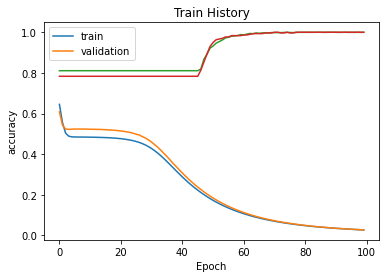

In [20]:
show_train_history(train_hist,'loss','val_loss')
show_train_history(train_hist,'accuracy','val_accuracy')

### &emsp;| (4) output df_bin

In [19]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

bin_data = []
for r in x:
    layer_outs = [func([np.array([[r]])]) for func in functors]
    for i,l in enumerate (layer_outs):
        for n in l:
            l_f = [s for xs in n.tolist() for s in xs]
            if i == bin_col_layer-1: bin_data.append(change_to_one_zero(l_f,0.2))

In [20]:
df_b = pd.DataFrame(bin_data)
df_b["GB"] = y
df_b

0  1  2  3  4  5  6  7  8  9  GB
0     0  0  1  0  0  0  1  0  1  0   1
1     1  1  0  1  0  0  0  0  0  0   0
2     1  1  0  1  0  0  0  0  0  0   0
3     1  1  0  1  0  0  0  0  0  0   0
4     1  1  0  1  0  0  0  0  0  0   0
...  .. .. .. .. .. .. .. .. .. ..  ..
2995  1  1  0  1  0  0  0  0  0  0   0
2996  1  1  0  1  0  0  0  0  0  0   0
2997  1  1  0  1  0  0  0  0  0  0   0
2998  1  1  0  1  0  0  0  0  0  0   0
2999  1  1  0  1  0  0  0  0  0  0   0

[3000 rows x 11 columns]

In [21]:
df_b.iloc[:,:n_bin_col].drop_duplicates().shape

(5, 10)

### &emsp;| (5) model vis

In [21]:
### important
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

In [22]:
from ann_visualizer.visualize import ann_viz
ann_viz(model, title="Artificial Neural network - Model Visualization")

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
from keras.utils.vis_utils import plot_model
keras.utils.vis_utils.plot_model(model,to_file='model.png',)

## <span style='color:Orange'>generate rnd binary data<span style='color:Orange'>

In [27]:
num_of_points =3000
type_one_ratio = 0.1
num_of_col = 33

In [28]:
categorical_data = [random.randint(0, 2**num_of_col) for _ in range(num_of_points)]
bin_data = ["{0:b}".format(xs) for xs in categorical_data]
col_gb = [1]*int(num_of_points*type_one_ratio)+[0]*int(num_of_points*(1-type_one_ratio))

In [29]:
new_data = []
for b in bin_data:
    while len(b)!=num_of_col: b="0"+b
    new_data.append([int(bi) for bi in b])
df_bin = pd.DataFrame(new_data)
df_bin["GB"] = col_gb
df_bin

0  1  2  3  4  5  6  7  8  9  ...  24  25  26  27  28  29  30  31  32  \
0     0  0  1  0  0  1  0  1  1  0  ...   1   1   1   0   1   0   1   0   0   
1     1  0  1  1  1  0  0  1  1  1  ...   1   0   0   1   1   0   0   0   0   
2     1  0  1  0  0  1  0  0  1  0  ...   1   1   1   1   0   0   0   1   0   
3     0  0  0  0  0  0  1  1  0  0  ...   1   1   0   0   1   1   0   0   0   
4     0  1  0  1  0  1  0  0  1  0  ...   1   0   0   1   0   1   0   1   1   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
2995  1  1  0  1  1  1  1  1  0  0  ...   1   0   0   0   0   1   0   1   0   
2996  0  0  1  1  0  0  1  1  1  1  ...   0   0   1   1   0   1   0   1   0   
2997  1  0  1  0  0  1  1  0  0  0  ...   1   1   0   1   0   0   1   0   1   
2998  0  1  1  0  0  0  1  1  1  1  ...   0   1   1   0   0   1   0   0   1   
2999  0  0  1  0  1  0  0  0  0  1  ...   0   1   1   1   1   0   0   1   1   

      GB  
0      1  
1      1  
2      1  
3      1  
4      1  
...   ..  
2995   0  
2996   0  
2997   0  
2998   0  
2999   0  

[3000 rows x 34 columns]

In [194]:
int('100101', 2)

37

In [200]:
"{0:b}".format(37)

'100101'

# **2. Grouping related columns**
---

## &emsp; -> <span style='color:white'>mis<span style='color:white'>

### &emsp; * <span style='color:white'>import<span style='color:white'>

In [13]:
import scipy.cluster.hierarchy as spc
from sklearn import manifold, datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import cluster, datasets
from sklearn.metrics import mean_squared_error
from plotly.colors import n_colors
import numpy as np
import pygad
from random import sample 
import plotly.graph_objects as go
from collections import Counter 
from plotly.subplots import make_subplots
import collections
import plotly.io as pio

### &emsp; * <span style='color:white'>Class<span style='color:white'>

In [236]:
class Grouped_Data:
    # 建構式
    def __init__(self,original_data, name):
        self.name = name
        self.n_group = original_data.n_group
        self.sep = original_data.sep
        self.cols = list(original_data.df_bin.columns)
        self.bin_feat = len(self.cols)-1
        
        self.df_bin = original_data.df_bin.copy()
        self.df_train = original_data.df_train.copy()
        self.df_test = original_data.df_test.copy()
        
    def set_seq(self, sequence):
        ### set columns sequencing
        if len(sequence)!=self.bin_feat: raise ValueError('len(seq) != len(columns)')
        self.seq = sequence
        self.seq_cols = [self.cols[i] for i in sequence]
        
    def set_col(self, c):
        ### set new columns name
        if len(c)!=self.n_group: raise ValueError('len(seq) != len(columns)')
        new_col = []
        for i, s in enumerate( self.sep[:-1]):
            new_col.append([f"{c[i]}-{n+1}" for n in range(0,self.sep[i+1]-s)] )
        new_col = [item for sublist in new_col for item in sublist]
        self.cols_new = new_col
        
    def group_df(self, ):
        ### group dataframe by new sequence
        if self.seq == None  or self.cols_new== None: raise ValueError('seq or col_new == NONE')
        seq_cols, cols, cols_new = self.seq_cols, self.cols, self.cols_new
        df_train, df_test, df_bin = self.df_train.copy(), self.df_test.copy(),self.df_bin.copy()
        
        self.df_sort = df_bin[[c for c in seq_cols] + [str(cols[-1])]]       
        self.df_train = df_train[[c for c in seq_cols] + [str(cols[-1])]] 
        self.df_test = df_test[[c for c in seq_cols] + [str(cols[-1])]] 
        
        self.df_train.columns = [cols_new + [str(cols[-1])]]
        self.df_test.columns = [cols_new + [str(cols[-1])]] 
        # if new_col_name:df_new.columns = cols_new+ [str(cols[-1])]
        # return df_new

## <span style='color:Orange'>xyz group<span style='color:Orange'>

In [237]:
# sep and col setting
ori_data=ori_data
gd_xyz = Grouped_Data(ori_data, "xyz")
gd_xyz.set_seq([i for i in range(0,gd_xyz.bin_feat)])
gd_xyz.set_col(["x","y","z"])
gd_xyz.group_df()

## <span style='color:lightblue'>Randomly group<span style='color:lightblue'>

In [238]:
# sep and col setting
ori_data= ori_data
gd_rnd = Grouped_Data(ori_data, "rnd")
gd_rnd.set_seq(random.sample([i for i in range(0, gd_rnd.bin_feat)],gd_rnd.bin_feat))
gd_rnd.set_col([f"r{i+1}" for i in range(0, len(gd_rnd.sep[:-1]))])
gd_rnd.group_df()

## <span style='color:purple'>Binary K-means<span style='color:DarkOliveGreen'>

### &emsp; * <span style='color:white'>class<span style='color:white'>

In [292]:
class Grouped_Data_Corr(Grouped_Data):
    # 建構式
    def __init__(self,original_data, name):
        self.name = name
        self.n_group = original_data.n_group
        self.sep = original_data.sep
        self.cols = list(original_data.df_bin.columns)
        self.bin_feat = len(self.cols)-1
        
        self.df_bin = original_data.df_bin.copy()
        self.df_train = original_data.df_train.copy()
        self.df_test = original_data.df_test.copy()
        
        # self.set_seq_by_corr()
        
    # 方法(Method)
#     def set_seq(self,):
#         df = self.df_train.iloc[:,:-1].corr()
#         corr = df.corr().values
#         corr[np.isnan(corr)] = 0
#         pdist = spc.distance.pdist(corr)
#         linkage = spc.linkage(pdist, method='complete')
#         idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
        
#         self.seq = list([ele for ele in idx])
#         self.seq_cols = [self.cols[i] for i in self.seq]
    
    def set_seq(self,):
        # https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix
        def score(C):
            '''
            Function to assign a score to an ordered covariance matrix.
            High correlations within a cluster improve the score.
            High correlations between clusters decease the score.
            '''
            score = 0
            for cluster in range(n_clusters):
                inside_cluster = np.arange(cluster_size) + cluster * cluster_size
                outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

                # Belonging to the same cluster
                score += np.sum(C[inside_cluster, :][:, inside_cluster])

                # Belonging to different clusters
                score -= np.sum(C[inside_cluster, :][:, outside_cluster])
                score -= np.sum(C[outside_cluster, :][:, inside_cluster])
#                 # Belonging to the same cluster
#                 score -= np.sum(C[inside_cluster, :][:, inside_cluster])

#                 # Belonging to different clusters
#                 score += np.sum(C[inside_cluster, :][:, outside_cluster])
#                 score += np.sum(C[outside_cluster, :][:, inside_cluster])
            return score
        
        def swap_rows(C, var1, var2):
            '''
            Function to swap two rows in a covariance matrix,
            updating the appropriate columns as well.
            '''
            D = C.copy()
            D[var2, :] = C[var1, :]
            D[var1, :] = C[var2, :]

            E = D.copy()
            E[:, var2] = D[:, var1]
            E[:, var1] = D[:, var2]
            return E
        
        df = self.df_train
        df_map = df.iloc[:,:-1].corr()
        C = df_map.values
        n_variables = C.shape[0]
        n_clusters = self.n_group
        # To keep this example simple, each cluster will have a fixed size
        cluster_size = n_variables // n_clusters
        #............................................................................................
        initial_C = C
        initial_score = score(C)
        initial_ordering = np.arange(n_variables)
        
        current_C = C
        current_ordering = initial_ordering
        current_score = initial_score
        max_iter = 1000
        for i in range(max_iter):
            # Find the best row swap to make
            best_C = current_C
            best_ordering = current_ordering
            best_score = current_score
            for row1 in range(n_variables):
                for row2 in range(n_variables):
                    if row1 == row2:
                        continue
                    option_ordering = best_ordering.copy()
                    option_ordering[row1] = best_ordering[row2]
                    option_ordering[row2] = best_ordering[row1]
                    option_C = swap_rows(best_C, row1, row2)
                    option_score = score(option_C)

                    if option_score > best_score:
                        best_C = option_C
                        best_ordering = option_ordering
                        best_score = option_score

            if best_score > current_score:
                # Perform the best row swap
                current_C = best_C
                current_ordering = best_ordering
                current_score = best_score
            else:
                # No row swap found that improves the solution, we're done
                break
        # self.co = current_ordering
        self.seq = list(current_ordering)
        self.seq_cols = [self.cols[i] for i in list(current_ordering)]
        
    def plot_corr_group(self, ):
        # encoder = sum_encoder
        df_dict = {'Bin.':self.df_bin, 'Corr.':self.df_sort}   
        dict_key = list(df_dict.keys())
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=(list(df_dict.keys())),)
        sns_colorscale = [[0.0, '#3f7f93'],[0.071, '#5890a1'],[0.143, '#72a1b0'],[0.214, '#8cb3bf'],[0.286, '#a7c5cf'],[0.357, '#c0d6dd'],[0.429, '#dae8ec'],[0.5, '#f2f2f2'],[0.571, '#f7d7d9'],[0.643, '#f2bcc0'],[0.714, '#eda3a9'],[0.786, '#e8888f'],[0.857, '#e36e76'],[0.929, '#de535e'],[1.0, '#d93a46']]
        for k in range (0, len(dict_key)):  
            pio.templates.default = "none"  
            df = df_dict[dict_key[k]]
            df_map = df.corr()
            corr_list = []
            for i in range(0, len(df.columns)):
                corr_list.append(df.corr().iloc[i,:i].values.tolist())
            X = df.columns
            hovertext = [[f'({X[i]}, {X[j]})= {corr_list[i][j]:.3f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
            show_text = [[f'{corr_list[i][j]:.2f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
            heat = go.Heatmap(z=corr_list,x=X,y=X,xgap=1, ygap=1,
                              colorscale="RdBu",zmin=-1,zmax=1,
                              text = show_text, texttemplate="%{text}",
                              colorbar_ticklen=1,colorbar_x=False,colorbar_thickness=10,
                              hovertext = hovertext,hoverinfo='text',)#colorbar_x=(k+1)/3-0.05)
            # adding trace
            fig.add_trace(heat,row=1, col=1+k)
        fig.update_yaxes(showgrid=False,autorange='reversed')
        fig.update_xaxes(showgrid=False)
        layout = go.Layout(title_text=f" Correlation Columns Grouping <br><sup>  </sup> ", title_x=0.5,)
        fig.update_layout(layout)        
        return fig

In [294]:
class Grouped_Data_Corr_ABS(Grouped_Data_Corr):
    # 建構式
    def __init__(self,original_data, name):
        self.name = name
        self.n_group = original_data.n_group
        self.sep = original_data.sep
        self.cols = list(original_data.df_bin.columns)
        self.bin_feat = len(self.cols)-1
        
        self.df_bin = original_data.df_bin.copy()
        self.df_train = original_data.df_train.copy()
        self.df_test = original_data.df_test.copy()
        
    def set_seq(self,):
        # https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix
        def score(C):
            '''
            Function to assign a score to an ordered covariance matrix.
            High correlations within a cluster improve the score.
            High correlations between clusters decease the score.
            '''
            score = 0
            for cluster in range(n_clusters):
                inside_cluster = np.arange(cluster_size) + cluster * cluster_size
                outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

                # Belonging to the same cluster
                score += np.sum(C[inside_cluster, :][:, inside_cluster])

                # Belonging to different clusters
                score -= np.sum(C[inside_cluster, :][:, outside_cluster])
                score -= np.sum(C[outside_cluster, :][:, inside_cluster])
#                 # Belonging to the same cluster
#                 score -= np.sum(C[inside_cluster, :][:, inside_cluster])

#                 # Belonging to different clusters
#                 score += np.sum(C[inside_cluster, :][:, outside_cluster])
#                 score += np.sum(C[outside_cluster, :][:, inside_cluster])

            return score
        
        def swap_rows(C, var1, var2):
            '''
            Function to swap two rows in a covariance matrix,
            updating the appropriate columns as well.
            '''
            D = C.copy()
            D[var2, :] = C[var1, :]
            D[var1, :] = C[var2, :]

            E = D.copy()
            E[:, var2] = D[:, var1]
            E[:, var1] = D[:, var2]
            return E
        
        df = self.df_train
        df_map = df.iloc[:,:-1].corr()
        C = df_map.values
        C = abs(C)
        n_variables = C.shape[0]
        n_clusters = self.n_group
        # To keep this example simple, each cluster will have a fixed size
        cluster_size = n_variables // n_clusters
        #............................................................................................
        initial_C = C
        initial_score = score(C)
        initial_ordering = np.arange(n_variables)
        
        current_C = C
        current_ordering = initial_ordering
        current_score = initial_score
        max_iter = 1000
        for i in range(max_iter):
            # Find the best row swap to make
            best_C = current_C
            best_ordering = current_ordering
            best_score = current_score
            for row1 in range(n_variables):
                for row2 in range(n_variables):
                    if row1 == row2:
                        continue
                    option_ordering = best_ordering.copy()
                    option_ordering[row1] = best_ordering[row2]
                    option_ordering[row2] = best_ordering[row1]
                    option_C = swap_rows(best_C, row1, row2)
                    option_score = score(option_C)

                    if option_score > best_score:
                        best_C = option_C
                        best_ordering = option_ordering
                        best_score = option_score

            if best_score > current_score:
                # Perform the best row swap
                current_C = best_C
                current_ordering = best_ordering
                current_score = best_score
            else:
                # No row swap found that improves the solution, we're done
                break
        # self.co = current_ordering
        self.seq = list(current_ordering)
        self.seq_cols = [self.cols[i] for i in list(current_ordering)]
        
class Grouped_Data_Corr_Squre(Grouped_Data_Corr):
    # 建構式
    def __init__(self,original_data, name):
        self.name = name
        self.n_group = original_data.n_group
        self.sep = original_data.sep
        self.cols = list(original_data.df_bin.columns)
        self.bin_feat = len(self.cols)-1
        
        self.df_bin = original_data.df_bin.copy()
        self.df_train = original_data.df_train.copy()
        self.df_test = original_data.df_test.copy()
    def set_seq(self,):
        # https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix
        def score(C):
            '''
            Function to assign a score to an ordered covariance matrix.
            High correlations within a cluster improve the score.
            High correlations between clusters decease the score.
            '''
            score = 0
            for cluster in range(n_clusters):
                inside_cluster = np.arange(cluster_size) + cluster * cluster_size
                outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

                # Belonging to the same cluster
                score += np.sum(C[inside_cluster, :][:, inside_cluster])

                # Belonging to different clusters
                score -= np.sum(C[inside_cluster, :][:, outside_cluster])
                score -= np.sum(C[outside_cluster, :][:, inside_cluster])
#                 # Belonging to the same cluster
#                 score -= np.sum(C[inside_cluster, :][:, inside_cluster])

#                 # Belonging to different clusters
#                 score += np.sum(C[inside_cluster, :][:, outside_cluster])
#                 score += np.sum(C[outside_cluster, :][:, inside_cluster])
            return score
        
        def swap_rows(C, var1, var2):
            '''
            Function to swap two rows in a covariance matrix,
            updating the appropriate columns as well.
            '''
            D = C.copy()
            D[var2, :] = C[var1, :]
            D[var1, :] = C[var2, :]

            E = D.copy()
            E[:, var2] = D[:, var1]
            E[:, var1] = D[:, var2]
            return E
        
        df = self.df_train
        df_map = df.iloc[:,:-1].corr()
        C = df_map.values
        C = C**2
        n_variables = C.shape[0]
        n_clusters = self.n_group
        # To keep this example simple, each cluster will have a fixed size
        cluster_size = n_variables // n_clusters
        #............................................................................................
        initial_C = C
        initial_score = score(C)
        initial_ordering = np.arange(n_variables)
        
        current_C = C
        current_ordering = initial_ordering
        current_score = initial_score
        max_iter = 1000
        for i in range(max_iter):
            # Find the best row swap to make
            best_C = current_C
            best_ordering = current_ordering
            best_score = current_score
            for row1 in range(n_variables):
                for row2 in range(n_variables):
                    if row1 == row2:
                        continue
                    option_ordering = best_ordering.copy()
                    option_ordering[row1] = best_ordering[row2]
                    option_ordering[row2] = best_ordering[row1]
                    option_C = swap_rows(best_C, row1, row2)
                    option_score = score(option_C)

                    if option_score > best_score:
                        best_C = option_C
                        best_ordering = option_ordering
                        best_score = option_score

            if best_score > current_score:
                # Perform the best row swap
                current_C = best_C
                current_ordering = best_ordering
                current_score = best_score
            else:
                # No row swap found that improves the solution, we're done
                break
        # self.co = current_ordering
        self.seq = list(current_ordering)
        self.seq_cols = [self.cols[i] for i in list(current_ordering)]

### &emsp; * <span style='color:white'>specific distance function k-means<span style='color:white'>

In [18]:
# gd_corr.df_train
# corr = gd_corr.df_train.corr().values
df = gd_corr.df_train.corr()
corr = df.corr().values
corr[np.isnan(corr)] = 0
pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

NameError: name 'gd_corr' is not defined

In [241]:
ori_data=ori_data
gd_corr = Grouped_Data_Corr(ori_data, "corr")
gd_corr.set_seq()
gd_corr.set_col(["c1","c2","c3"])
gd_corr.group_df()

In [242]:
ori_data=ori_data
gd_corrABS = Grouped_Data_Corr_ABS(ori_data, "corr")
gd_corrABS.set_seq()
gd_corrABS.set_col(["c1","c2","c3"])
gd_corrABS.group_df()
# Grouped_Data_Corr_ABS

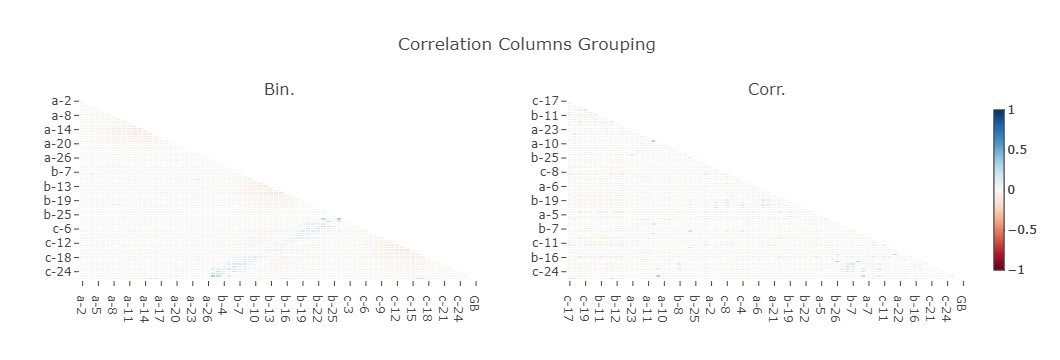

In [21]:
gd_corr.plot_corr_group()

In [172]:
import pandas as pd
import scipy.cluster.hierarchy as spc
# https://stackoverflow.com/questions/52787431/create-clusters-using-correlation-matrix-in-python

df = gd_corr.df_bin
corr = df.corr().values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

In [177]:
df = gd_corr.df_train.iloc[:,:-1].corr()
corr = df.corr().values
# corr[np.isnan(corr)] = 0
pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

ValueError: The condensed distance matrix must contain only finite values.

In [178]:
idx

array([62, 36, 51, 38, 34, 54,  5, 43,  4, 40, 33, 37, 11, 61, 56, 57, 35,
       22, 27, 42, 30,  4, 14, 18, 55, 19, 44,  8,  2, 58, 21,  3,  1, 11,
       13, 23, 25, 32, 34, 24, 60, 59, 43, 26, 46, 50, 15, 63, 45, 39,  6,
       12,  7,  7, 41, 16,  6, 53, 10, 28,  9, 13, 50,  2, 64, 31, 47, 62,
       48, 20, 31, 29, 49,  9,  1,  3, 52,  2, 17,  8], dtype=int32)

In [179]:
l = idx
[number for number in list(l) if list(l).count(number) > 1]

[62,
 34,
 43,
 4,
 11,
 4,
 8,
 2,
 3,
 1,
 11,
 13,
 34,
 43,
 50,
 6,
 7,
 7,
 6,
 9,
 13,
 50,
 2,
 31,
 62,
 31,
 9,
 1,
 3,
 2,
 8]

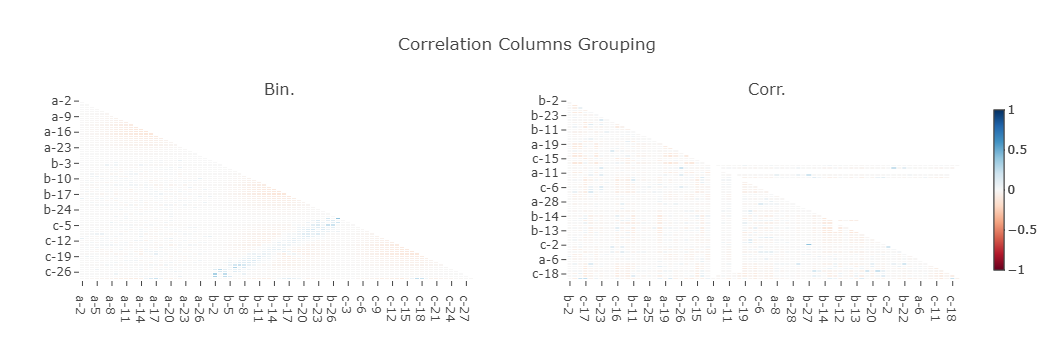

In [151]:
df_dict = {'Bin.':gd_corr.df_bin, 'Corr.':gd_corr.df_sort}#df[[list(df.columns)[c-1] for c in idx ]]}   
dict_key = list(df_dict.keys())
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=(list(df_dict.keys())),)
sns_colorscale = [[0.0, '#3f7f93'],[0.071, '#5890a1'],[0.143, '#72a1b0'],[0.214, '#8cb3bf'],[0.286, '#a7c5cf'],[0.357, '#c0d6dd'],[0.429, '#dae8ec'],[0.5, '#f2f2f2'],[0.571, '#f7d7d9'],[0.643, '#f2bcc0'],[0.714, '#eda3a9'],[0.786, '#e8888f'],[0.857, '#e36e76'],[0.929, '#de535e'],[1.0, '#d93a46']]
for k in range (0, len(dict_key)):  
    pio.templates.default = "none"  
    df = df_dict[dict_key[k]]
    df_map = df.corr()
    corr_list = []
    for i in range(0, len(df.columns)):
        corr_list.append(df.corr().iloc[i,:i].values.tolist())
    X = df.columns
    hovertext = [[f'({X[i]}, {X[j]})= {corr_list[i][j]:.3f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
    show_text = [[f'{corr_list[i][j]:.2f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
    heat = go.Heatmap(z=corr_list,x=X,y=X,xgap=1, ygap=1,
                      colorscale="RdBu",zmin=-1,zmax=1,
                      text = show_text, texttemplate="%{text}",
                      colorbar_ticklen=1,colorbar_x=False,colorbar_thickness=10,
                      hovertext = hovertext,hoverinfo='text',)#colorbar_x=(k+1)/3-0.05)
    # adding trace
    fig.add_trace(heat,row=1, col=1+k)
fig.update_yaxes(showgrid=False,autorange='reversed')
fig.update_xaxes(showgrid=False)
layout = go.Layout(title_text=f" Correlation Columns Grouping <br><sup>  </sup> ", title_x=0.5,)
fig.update_layout(layout)   
# fig.to_html()

In [153]:
gd_corr.df_sort

b-2  a-14  a-17  c-17  b-21  a-18  b-23  b-4  c-3  c-16  ...  c-11  \
0       0     0     0     0     0     0     0    0    0     0  ...     0   
1       0     0     0     0     0     0     0    0    0     0  ...     0   
2       0     1     0     0     0     0     0    0    0     0  ...     0   
3       0     0     0     0     0     0     0    0    0     0  ...     0   
4       0     0     0     0     0     0     0    0    0     0  ...     0   
...   ...   ...   ...   ...   ...   ...   ...  ...  ...   ...  ...   ...   
3295    0     0     0     0     0     0     0    0    0     0  ...     0   
3296    0     0     0     0     0     0     0    0    0     1  ...     0   
3297    0     0     1     0     0     0     0    0    0     0  ...     0   
3298    0     0     1     0     0     0     0    0    0     0  ...     0   
3299    0     0     0     0     0     0     0    0    0     1  ...     0   

      c-14  c-23  c-21  c-4  c-18  c-5  c-20  a-3  GB  
0        1     0     0    0     0    0     0    0   0  
1        0     0     0    0     0    0     0    0   0  
2        0     0     0    0     0    0     0    0   0  
3        1     0     0    0     0    0     0    0   0  
4        0     0     0    0     1    0     0    0   0  
...    ...   ...   ...  ...   ...  ...   ...  ...  ..  
3295     0     0     0    0     1    0     0    0   1  
3296     0     0     0    0     0    0     0    0   1  
3297     0     0     0    0     1    0     0    0   1  
3298     0     0     0    0     1    0     0    0   1  
3299     0     0     0    0     0    0     0    0   1  

[3300 rows x 81 columns]

In [152]:
fig_path = rf"C:\Users\User\Desktop\Terry\Data\Output\corr.html"
with open(fig_path, 'a') as f:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

## <span style='color:brown'>PCA weight group<span style='color:brown'>

### &emsp;&emsp; * <span style='color:white'>Class<span style='color:white'>

In [37]:
class Grouped_Data_PCA(Grouped_Data):
    # 建構式
    def __init__(self,original_data, name):
        self.name = name
        self.n_group = original_data.n_group
        self.sep = original_data.sep
        self.cols = list(original_data.df_bin.columns)
        self.bin_feat = len(self.cols)-1

        self.df_bin = original_data.df_bin.copy()
        self.df_train = original_data.df_train.copy()
        self.df_test = original_data.df_test.copy()
        # self.df_sort = original_data.df_sort.copy()
    # 方法(Method)
    def set_seq(self,):
        df=self.df_train.copy()
        self.pca = PCA(n_components=len(df.columns)-1)
        self.pca.fit(df.T[:-1].T)
        seleceted_cols, new_column= [],[]
        for p in range(0,self.n_group):
            X,Y = list(df.columns)[:-1],[abs(w) for w in self.pca.components_[p]]
            l = [x for _,x in sorted(zip(Y,X))]
            l.reverse()
            l = [ele for ele in l if ele not in seleceted_cols]
            [seleceted_cols.append(ele) for ele in l[0:self.sep[p+1]-self.sep[p]]]
        self.seq_cols = seleceted_cols
        self.seq = [list(self.cols).index(c) for c in seleceted_cols]
        
    def plot_pca_group(self,):
        def cell_fill_color_pca(df,colors):
            def OX_to_num(s):
                l = []
                for c in s:
                    if c == "O":l.append(1)
                    else: l.append(0)
                return l  
            main_cell = [[np.array(colors)[OX_to_num(df.transpose().values.tolist()[col])]]*3 for col in range(3,12,3)]
            pca_color = [['rgb(255.0, 255, 255)']*len(df)] + [x for xs in main_cell for x in xs]
            return pca_color
        # sep 
        df = pd.DataFrame([f"{int(i)}." for i in range(1,self.bin_feat+1)],columns = [["<b>weight NO.</b>"],[""]])
        for i,sp in enumerate( self.sep[:-1]):
            X,Y = list(self.df_bin.columns), [abs(w) for w in self.pca.components_[i]]
            c = [x for _,x in sorted(zip(Y,X))]
            c.reverse()
            w = sorted(Y)
            w.reverse()
            w = ['{:.4f}'.format(elem) for elem in w]
            s = []
            for ele in c:
                if ele in self.seq_cols[sp:self.sep[i+1]]:s.append("O")
                else: s.append("X")            
            
            df_pc = pd.DataFrame([c,w,s],).T
            df_pc.columns = [[f"<b> PC {i+1} </b>","",""],["<I>column</I>", "<I>weight</I>", "<I>select</I>"]]
            df = pd.concat([df, df_pc], axis=1)

        cell_color = cell_fill_color_pca(df, n_colors('rgb(255, 213, 213)', 'rgb(68, 198, 102)', 2, colortype='rgb'))
        fig = go.Figure(data=[go.Table(
            header=dict(values=df.columns,line_color='gray',fill_color='rgb(189, 215, 231)',align='center'),
            cells=dict(values=df.transpose().values.tolist(),    line_color="gray",fill_color=cell_color,font=dict(color='Black', size=13),align='center'))])
        fig.update_layout(title=f"PCA Column Grouping  <br><sup> {self.name} </sup> ",)
        return fig

### &emsp;| (1) build PCA

In [55]:
ori_data= ori_data
gd_PCA = Grouped_Data_PCA(ori_data, "PCA")
gd_PCA.set_seq()
gd_PCA.set_col(["pc1","pc2","pc3"])
gd_PCA.group_df()

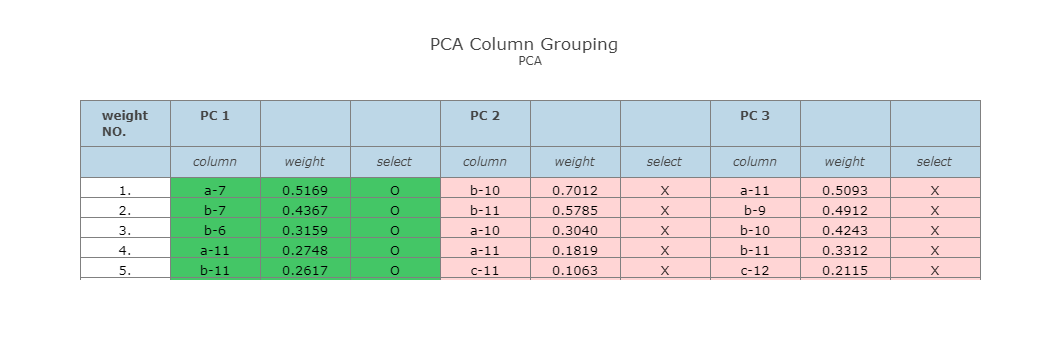

In [56]:
gd_PCA.plot_pca_group()

## <span style='color:DarkOliveGreen'>GA(supervised)<span style='color:DarkOliveGreen'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

####  &emsp;  &emsp; -GA

#####  &emsp;  &emsp;  &emsp; &emsp;  --record

In [ ]:
# record 
def on_generation(ga):
    print("Generation", ga.generations_completed)
    print(ga.population)
    
def on_fitness(ga, population_fitness):
    avg = sum(ga_instance.last_generation_fitness)/len(ga_instance.last_generation_fitness)
    maximul = max(ga_instance.last_generation_fitness)
    ft_iteration_avg.append(avg)
    ft_iteration_best.append(maximul)
    if ft_so_far_the_best:
        if max(ft_so_far_the_best)<=maximul:ft_so_far_the_best.append(maximul)
        else:ft_so_far_the_best.append(ft_so_far_the_best[-1])
    else:ft_so_far_the_best.append(maximul)

#####  &emsp;  &emsp;  &emsp; &emsp;  --crossover

In [16]:
# crossover
def order_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pt = sorted(sample(p1,2))
        p1_ele = [p1[e] for e in range(cut_pt[0],cut_pt[1]+1)]
        p2_ele = [p for p in p2 if p not in p1_ele]

        offspring.append(p2_ele[0:cut_pt[0]]+p1_ele+p2_ele[cut_pt[0]:])
        idx += 1
    return np.array(offspring)

def position_based_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pts = sorted(sample(p1,sample(p1,1)[0]))
        p1_ele = [p1[e] for e in cut_pts]
        p2_ele = [p for p in p2 if p not in p1_ele]
        
        c,e=[],0
        for i in cut_pts:
            c,e = p2_ele.insert(i,p1_ele[e]),e+1
            
        offspring.append(p2_ele)
        idx += 1

    return np.array(offspring)

#####  &emsp;  &emsp;  &emsp; &emsp;  --mutation

In [17]:
# mutation
def swap_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        mut_pt = sorted(sample(c,2))
        c[mut_pt[0]], c[mut_pt[1]] = c[mut_pt[1]], c[mut_pt[0]]
        offspring[chromosome_idx] = np.array(c)
    return offspring

def scramble_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        cut_pt = sorted(sample(c,2))
        scrable_ele = c[cut_pt[0]:cut_pt[1]+1]
        offspring[chromosome_idx] = np.array(c[0:cut_pt[0]]+sample(scrable_ele,len(scrable_ele))+c[cut_pt[1]+1:])
    return offspring

#####  &emsp;  &emsp;  &emsp; &emsp;  --fittness

In [19]:
# fittness

def min_type1_dis_fitness(solution, solution_idx): # need df_1 and l_col
    n_data = []
    n_oreder = [l_col[i] for i in solution]
    df_new = df_1[n_oreder]
    for r in range(0,len(df_1)):
        # df_1.iloc[r,:]
        n_data.append(encode_category(df_new.iloc[r,:]))
    return -mean_squared_error(n_data, [sum(n_data)/len(n_data)]*len(n_data))

def max_ssb_ssw_fitness(solution, solution_idx):
    X,Y = [],[]
    n_oreder = [l_col[i] for i in solution]
    df_0_new = df_0[n_oreder]
    df_1_new = df_1[n_oreder]
    for r in range(0,len(df_0)):
        X.append(encode_category(df_0_new.iloc[r,:]))
    for r in range(0,len(df_1)):
        Y.append(encode_category(df_1_new.iloc[r,:]))
    SST = sum([(t - np.mean(X+Y))**2 for t in X+Y])
    SSE = sum([(x - np.mean(X))**2 for x in X])+sum([(y - np.mean(Y))**2 for y in Y])
    SSB = SST-SSE
    return SSB/SSE

####  &emsp;  &emsp; -plot

In [658]:
def plot_GA_evolve(ft_iteration_best,ft_so_far_the_best,ft_iteration_avg):
    # Create traces
    x = [i for i in range(1,num_generations+1)]
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=x, y=ft_iteration_best,
                        mode='lines',name='iteration the best'))
    fig.add_trace(go.Scatter(x=x, y=ft_so_far_the_best,
                        mode='lines',name='so far the best'))
    fig.add_trace(go.Scatter(x=x, y=ft_iteration_avg,
                        mode='lines', name='iteration average'))
    fig.update_layout(title="Binary column permutation",xaxis_title="Generation",yaxis_title="Fitness",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig
# fig.show()

In [659]:
def arrange_col_by_order(df_bin, order):
    n_data = []
    n_oreder = list(order)
    df_new = df_bin.copy()[n_oreder]
    for r in range(0,len(df_bin)):
        n_data.append(encode_category(df_new.iloc[r,:]))
    df_new = pd.DataFrame(n_data)
    df_new["GB"] = df_bin.GB
    return df_new

def get_cumulated_points(df):
    ordered_dict = collections.OrderedDict(sorted(Counter(df[df.columns[0]]).items()))
    x,y = [],[]
    cum = 0
    for c in ordered_dict:
        cum+=ordered_dict[c]
        x.append(c)
        y.append(cum)
    new_y = []
    for o in y:
        if o and max(y)!=0: new_y.append(o/max(y))
        else:new_y.append(0)
    return x,new_y

def plot_encode_axis(df, name):
    fig = make_subplots(rows=2, cols=1, shared_xaxes='all')#, column_widths=[0.7, 0.3])
    df_1 = df.loc[df.GB==1]
    df_0 = df.loc[df.GB==0]
    x1,y1 = get_cumulated_points(df_1)
    x0,y0 = get_cumulated_points(df_0)

    fig.add_trace(go.Scatter(x=df_0[df.columns[0]],y=len(df_0)*[f"GB=0"],mode='markers', marker=dict(color="blue"),
                             name=f"GB=0, [{len(df_0)}]",),row=1, col=1)
    fig.add_trace(go.Scatter(x=df_1[df.columns[0]],y=len(df_1)*["GB=1"],mode='markers', marker=dict(color="red"),
                             name=f"GB=1, [{len(df_1)}]",),row=1, col=1)

    fig.add_trace(go.Scatter(x=x1, y=y1,mode='lines',marker_color='red',name='cum 1')
                  ,row=2, col=1)
    fig.add_trace(go.Scatter(x=x0, y=y0,mode='lines',marker_color='blue',name='cum 2')
                  ,row=2, col=1)

    for trace in fig['data']: 
        if("cum" in trace['name']): trace['showlegend'] = False
    fig.update_layout(title=f"Encoding result, {name}",xaxis2_title="Categorical variable",#yaxis_title="Type",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

### &emsp;| (1) build GA model

In [300]:
# GA settings
num_genes = len(df_bin.columns[:-1])
init_range_low = 0
init_range_high = num_genes

num_generations = 30
sol_per_pop = 10

In [301]:
# Dataframe para
df = df_bin
df_0 = df_bin.loc[df_bin.GB==0].copy()
df_1 = df_bin.loc[df_bin.GB==1].copy()
l_col = df_bin.columns[:-1].tolist()

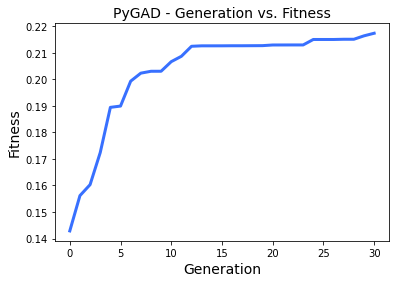

In [302]:
ft_iteration_avg = []
ft_iteration_best = []
ft_so_far_the_best = []

crossover_type = position_based_crossover
mutation_type = scramble_mutation
fitness_func = max_ssb_ssw_fitness

ga_instance = pygad.GA(num_generations=num_generations,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       
                       parent_selection_type="sss",
                       
                       crossover_type=crossover_type,
                       crossover_probability=0.8,
                       
                       mutation_type=mutation_type,
                       mutation_probability = 0.2,
                         
                       num_parents_mating=2,
                       fitness_func=fitness_func,
                       
                       gene_type=int,
                       gene_space=[i for i in range(init_range_low,init_range_high)],
                       
                       on_fitness = on_fitness,
                       allow_duplicate_genes=False,
                      )
ga_instance.run()
ga_instance.plot_result()
print()

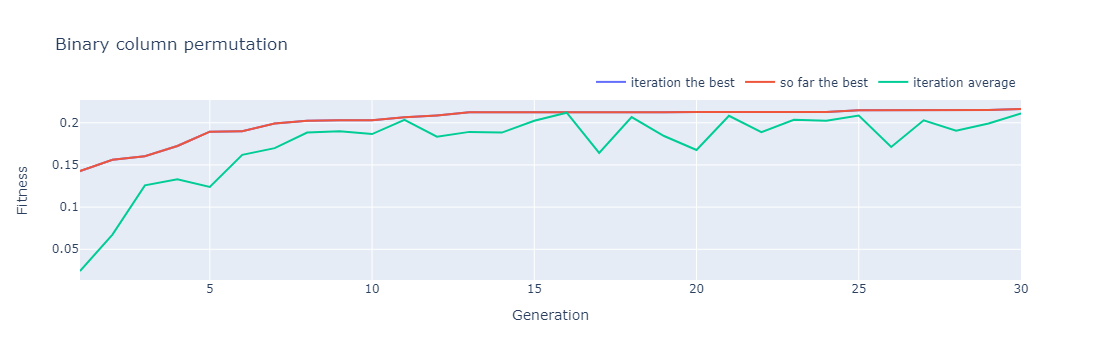

In [303]:
fig = plot_GA_evolve(ft_iteration_best,ft_so_far_the_best,ft_iteration_avg)
fig

In [92]:
fig.write_html(r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\GA evovle.html")

### &emsp;| (2) encoding result

In [607]:
df_ori = arrange_col_by_order(df_bin,df_bin.columns[:-1])
plot_encode_axis(df_ori, "(original sequence)")# df_new

NameError: name 'arrange_col_by_order' is not defined

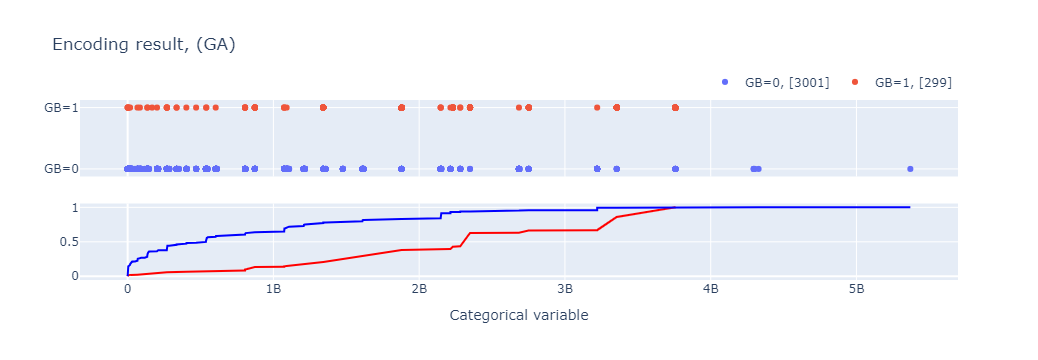

In [305]:
df_ga = arrange_col_by_order(df_bin,[l_col[i] for i in list(ga_instance.best_solution()[0])])
plot_encode_axis(df_ga, "(GA)")

## <span style='color:purple'>Brutal Force(supervised)<span style='color:DarkOliveGreen'>

In [46]:
import itertools

In [ ]:
per = list(itertools.permutations([i for i in range(0, len(df_bin.columns[:-1]))]))
fitness = [fitness_func(f,_) for f in per]

In [ ]:
pd.DataFrame([per,fitness], index = ["combination", "fitness"]).T

In [ ]:
max(fitness)

# **3. Encoding**
---

## &emsp; -> <span style='color:white'>mis<span style='color:white'>

### &emsp; * <span style='color:white'>import<span style='color:white'>

In [38]:
import collections
from sklearn.preprocessing import Normalizer
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Label, Button
from ipywidgets import IntSlider
import random
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
import os
import plotly.io as pio
import random
pio.templates.default = "none"  

### &emsp; * <span style='color:white'>fun<span style='color:white'>

####  &emsp;  &emsp; -encoding

#####  &emsp;  &emsp;  &emsp; &emsp;  --seq, rule, encode

In [39]:
### sequence
# def cal_list_dos(X): # calculate distance ( from average to 0.5 )
#     bal_list = []
#     avg_list = cal_list_avg(X)
#     for avg in avg_list: 
#         bal_list.append(abs(avg-0.5))
#     return bal_list 

def seq_sum(df): 
    return [sum(df[c]) for c in df][:-1]

def seq_ID(df):
    return [a for a in range(0,len(df.T)-1)]

def seq_rnd(df): 
    ran = [a for a in range(0,len(df.T)-1)]
    random.Random().shuffle(ran)
    return ran 

def seq_ratio(df): 
    df_1 = df.loc[df[df.columns[-1]] == 1]
    ratio = []
    for i,col in enumerate(df.T[:-1].values): 
        # print(sum(col),sum(df_1.iloc[:,i]),sum(df_1.iloc[:,i])/sum(col))
        ratio.append(sum(df_1.iloc[:,i])/sum(col))
    return ratio

### sorting rule
def sort_SmallToLarge(seq_l_data, data_l_data):  # from small to large
    seq_l,data_l = seq_l_data.copy(),data_l_data.copy()
    for i in range(len(seq_l)):
        swap = i + np.argmin(seq_l[i:])
        (seq_l[i], seq_l[swap]) = (seq_l[swap], seq_l[i])
        (data_l[i], data_l[swap]) = (data_l[swap], data_l[i])
    return data_l

def sort_LargeToSmall(seq_l_data, data_l_data): # from large to small
    seq_l,data_l = seq_l_data.copy(),data_l_data.copy()
    for i in range(len(seq_l)):
        swap = i + np.argmax(seq_l[i:])
        (seq_l[i], seq_l[swap]) = (seq_l[swap], seq_l[i])
        (data_l[i], data_l[swap]) = (data_l[swap], data_l[i])
    return data_l

def sort_normal(seq_l_data, data_l_data):  # make to be normal
    seq_l,data_l = solve_duplicates( seq_l_data.copy()),data_l_data.copy()
    new_data = []
    while(len(seq_l)!=0):
        element = data_l[seq_l.index(max(seq_l))]
        if len(seq_l) % 2 == 0:new_data.insert(0,element)
        else:new_data.append(element)
        del data_l[seq_l.index(max(seq_l))]
        seq_l.remove(max(seq_l))       
    return new_data

### encoding methods
def encode_category(array):
    for i in array:
        if i != 0 and i!=1:
            raise ValueError(f'all input needs to be 0 or 1 {array}')
    x = [f"{n}" for n in array]
    s = ''.join(x)
    return int(s,2)

def encode_grid(array):
    for i in array:
        if i != 0 and i!=1:
            raise ValueError(f'all input needs to be 0 or 1 {array}')
    if sum(array) != 1:
        raise ValueError(f'sum of input must be 1 {array}')      
    d = 1
    for i in array:
        if i == 1:
            break
        d+=1
    return len(array) - d

#####  &emsp;  &emsp;  &emsp; &emsp;  --main funs

In [40]:
def perform_encoding(df_data, seq_fun, encode_fun, sort_fun, sep_list=None, new_col_name=None):
    df = df_data.copy()
    if sep_list == None and new_col_name == None:
        sep_list, new_col_name = get_sep_and_new_col_list(df)
    seq = seq_fun(df.values)
    new_data = []
    for row in df.values: 
        new_row_list = [] 
        for i in range(0, len(sep_list)-1):
            arr = []
            b = seq[sep_list[i]:sep_list[i+1]]
            r = row[sep_list[i]:sep_list[i+1]]      
            arr = sort_fun(b,r.tolist())
            num = encode_fun(arr)
            new_row_list.append(num)
            
        new_data.append(new_row_list)
    
    # make new dataframe
    df_new = pd.DataFrame(new_data)
    df_new.columns = new_col_name
    df_new = df_new.set_index(df.index) 
    df_new["GB"] = df["GB"]
    return df_new

def get_sep_and_new_col_list(df_data):
    df = df_data.copy()
    col = df.columns[:-1]
    pre_c = col[0].split('-')[0]

    sep_list = [0]
    new_col_name = [pre_c]
    for i in range(0,len(col)):
        new_c = col[i].split('-')[0]
        if pre_c != new_c:
            sep_list.append(i)
            new_col_name.append(new_c)
        pre_c = new_c
    sep_list.append(len(col))
    return sep_list, new_col_name

def generate_new_sep_and_feat(n_cols):   
    feat = [chr(945+i) for i in range(0, len(n_cols))]
    sep,sum_ = [0],0
    for s in n_cols:
        sum_ += s
        sep.append(sum_)  
    return sep, feat

def solve_duplicates(arr_data):
    arr = arr_data.copy()
    interval = 1/len(arr)
    duplicates = [item for item, count in collections.Counter(arr).items() if count > 1]
    for d in duplicates:
        for i in range(0,len(arr)):
            if arr[i] == d:
                arr[i] = d + i*interval
    # print(arr)
    return arr

# change df range
def rerange(df_data, with_in_01):
    df = df_data.copy()
    n_df =(df-df.min())/(df.max()-df.min())

    if  with_in_01==False:
        for i in range(0, len(sep_list)-1):
            g = sep_list[i+1]-sep_list[i]
            n_df.iloc[:,i] = n_df.iloc[:,i] * g

    return n_df

####  &emsp;  &emsp; -compare plot

#####  &emsp;  &emsp;  &emsp; &emsp;  --3D, corrmap, axis plot

In [41]:
def plot_encoded_axis(encoder, df_encode):
    fig = make_subplots(rows=3, cols=2,subplot_titles=(["Sorted Bin.", "Encoded"]))
    
    # adding df_cont trace
    df = encoder.df_sort.copy()
    count_list = []
    for i in range(0, len(ori_data.sep)-1):
        df_bin_new = df.iloc[:,ori_data.sep[i]:ori_data.sep[i+1]]
        count_0, count_1,x= [],[],[]
        for c in df_bin_new:
            x.append(c)
            count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
            count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=1)
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=1)
# cont_cols, encode_col=list(ori_data.df_read.columns)[:-1],[gd_data.cols_new[s].split("-")[0]  for s in gd_data.sep[:-1]]
# fig.update_layout(barmode='stack',title = f"Binary Axis Distribution <br><sup> {gd_data.name} </sup> "
#                  ,yaxis1_title=cont_cols[0],yaxis4_title=cont_cols[1],yaxis7_title=cont_cols[2]
#                  ,yaxis3_title=encode_col[0],yaxis6_title=encode_col[1],yaxis9_title=encode_col[2])

    dict_df = {"Sorted bin.":df_encode}#, "Encode":df_encode}
    cols = list(df_encode.columns)[:-1]
    for key in dict_df:  
        df = dict_df[key]
        cols_id = list(dict_df.keys()).index(key)+1
        for j in range (0, len(df.columns)-1):
            # print(j+1, cols_id)
            X = df[df.columns[j]].loc[df.GB == 0]
            fig.add_trace(go.Histogram(x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=2)
            X = df[df.columns[j]].loc[df.GB == 1]
            fig.add_trace(go.Histogram(x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=2)    
            
    fig.update_layout(barmode='stack',title = f"Encoded Result<br><sup> {encoder.name} </sup> "
                      ,yaxis1_title=cols[0],yaxis3_title=cols[1],yaxis5_title=cols[2])
    return fig

def plot_bin_axis(ori_data, gd_data):
    fig = make_subplots(rows=3, cols=3,subplot_titles=(['Conti.','Bin.','Grouped Bin.']))
    # adding df_cont trace
    df = ori_data.df_read
    for j in range (0, len(df.columns)-1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)

    dict_df = {"Encode":ori_data.df_bin, "Sorted Encoded":gd_data.df_sort}
    for key in dict_df:  
        df = dict_df[key]
        cols_id = list(dict_df.keys()).index(key)+2
        count_list = []
        for i in range(0, len(ori_data.sep)-1):
            df_bin_new = df.iloc[:,ori_data.sep[i]:ori_data.sep[i+1]]
            count_0, count_1,x= [],[],[]
            for c in df_bin_new:
                x.append(c)
                count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
                count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
            fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=cols_id)
            fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=cols_id)
    cont_cols,bin_cols, encode_col=list(ori_data.df_read.columns)[:-1],[ori_data.df_bin.columns[s].split("-")[0]  for s in ori_data.sep[:-1]],[gd_data.cols_new[s].split("-")[0]  for s in gd_data.sep[:-1]]
    fig.update_layout(barmode='stack',title = f"Binary Axis Distribution <br><sup> {gd_data.name} </sup> "
                     ,yaxis1_title=cont_cols[0],yaxis4_title=cont_cols[1],yaxis7_title=cont_cols[2]
                     ,yaxis3_title=encode_col[0],yaxis6_title=encode_col[1],yaxis9_title=encode_col[2])
    return fig

In [42]:
def plot_3d(ori_data, encoder, df_encode):
    list_name = [f'Original {ori_data.df_read.drop_duplicates().shape}',
     f'Encoded {df_encode.drop_duplicates().shape}']
    df_dict = {list_name[0]:ori_data.df_read, list_name[1]:df_encode}
    dict_key = list(df_dict.keys())
    
    alpha = 0.3
    fig = make_subplots(rows=2, cols=2,specs=[[{'type': 'surface'}, {'type': 'surface'}],
                                              [{'type': 'surface'}, {'type': 'surface'}]],
                        subplot_titles=(dict_key+[f"PCA on {dict_key[0]}", f"PCA on {dict_key[1]}"]))
    # original scatter
    for k in range (0, len(dict_key)):
        df = df_dict[dict_key[k]]
        df1 = df.loc[df[df.columns[-1]] == 1]
        df0 = df.loc[df[df.columns[-1]] == 0]
        GB_1 = go.Scatter3d(x=df1[df.columns[0]], y=df1[df.columns[1]], z=df1[df.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=1), showlegend=True, name = "GB_1")#,legendgroup=k,)
        GB_0 = go.Scatter3d(x=df0[df.columns[0]], y=df0[df.columns[1]], z=df0[df.columns[2]],mode='markers', marker=dict(size=3, color = "blue", opacity=0.5), showlegend=True, name = "GB_0")#,legendgroup=k,)
        fig.add_trace(GB_1,row=1, col=k+1)
        fig.add_trace(GB_0,row=1, col=k+1)
    # PCA line
    for k in range (0, len(dict_key)):  
        df = df_dict[dict_key[k]]
        data,target = df.iloc[:,:-1],df.iloc[:,-1:]
        pca = PCA(n_components=3).fit(data)
        X_reduced = pca.transform(data)
        
        x_reduce = go.Scatter3d(x = X_reduced[:,0],y = X_reduced[:,1],z = X_reduced[:,2],
                                    mode='markers', marker=dict(size=2,colorscale='Bluered',color= df.GB,  opacity=alpha))
        var1 = go.Scatter3d( x = [0,pca.components_.T[0][0]],y = [0,pca.components_.T[0][1]],z = [0,pca.components_.T[0][2]],
                            marker = dict( size = 1,color = "rgb(84,48,5)",),
                            line = dict( color = "red",width = 6),
                            legendgroup=f"group{k+1}",
                            name = list(df.columns)[0])
        var2 = go.Scatter3d( x = [0,pca.components_.T[1][0]],y = [0,pca.components_.T[1][1]],z = [0,pca.components_.T[1][2]],
                            marker = dict( size = 1,color = "rgb(84,48,5)"),
                            line = dict( color = "green",width = 6),
                            legendgroup=f"group{k+1}",
                            name = list(df.columns)[1])
        var3 = go.Scatter3d( x = [0,pca.components_.T[2][0]],y = [0,pca.components_.T[2][1]],z = [0,pca.components_.T[2][2]],
                            marker = dict( size = 1,color = "rgb(84,48,5)"),
                            line = dict( color = "blue",width = 6),
                            legendgroup=f"group{k+1}",
                            name = list(df.columns)[2]) 
        fig_data = [x_reduce, var1, var2, var3]
        fig.add_trace(x_reduce,row=2, col=k+1)
        fig.add_trace(var1,row=2, col=k+1)    
        fig.add_trace(var2,row=2, col=k+1) 
        fig.add_trace(var3,row=2, col=k+1)
        
    fig.update_layout(title_text=" " , title_x=0.5)
    fig.update_layout(xaxis =  {'showgrid': False},yaxis = {'showgrid': True},
                      scene2=dict(xaxis_title=list(df_encode.columns)[0],yaxis_title=list(df_encode.columns)[1],zaxis_title=list(df_encode.columns)[2]),
                      scene3=dict(xaxis_title='PC 1',yaxis_title='PC 2',zaxis_title='PC 3'),
                      scene4=dict(xaxis_title='PC 1',yaxis_title='PC 2',zaxis_title='PC 3'),
                      title_text=f'Scatter Plot  <br><sup>{encoder.name}</sup> ',)
    
    labels_to_show_in_legend = list(ori_data.df_read.columns)[:-1]+list(df_encode.columns)[:-1]
    for trace in fig['data']: 
        if (not trace['name'] in labels_to_show_in_legend):
            trace['showlegend'] = False
    return fig

###..............................................................................................................................
def plot_axis_new(ori_data, encoder, df_encode):
    fig = make_subplots(rows=3, cols=4,subplot_titles=(['Conti.','Bin.','Sorted Bin.','Encode']))
    # adding df_cont trace
    df = ori_data.df_read
    for j in range (0, len(df.columns)-1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)

    # adding df_bin trace
    df = ori_data.df_bin
    count_list = []
    for i in range(0, len(ori_data.sep)-1):
        df_bin_new = df.iloc[:,ori_data.sep[i]:ori_data.sep[i+1]]
        count_0, count_1,x= [],[],[]
        for c in df_bin_new:
            x.append(c)
            count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
            count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=2)
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=2)
    
    # adding sorted bin df trace
    df = encoder.df_sort
    count_list = []
    for i in range(0, len(ori_data.sep)-1):
        df_bin_new = df.iloc[:,ori_data.sep[i]:ori_data.sep[i+1]]
        count_0, count_1,x= [],[],[]
        for c in df_bin_new:
            x.append(c)
            count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
            count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=3)
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=3)
        
    # adding df_cont trace
    df = df_encode
    for j in range (0, len(df.columns)-1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=4)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=4)    
    
    fig.update_layout(barmode='stack',title = f" Axis distribution <br><sup> {encoder.name} </sup> ")
    return fig

###..............................................................................................................................
def plot_axis(ori_data, encoder, df_encode):
    fig = make_subplots(rows=3, cols=3,subplot_titles=(['x','a','α','y','b','β','z','c','γ']))
    # adding df_cont trace
    df = ori_data.df_read
    for j in range (0, len(df.columns)-1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)

    # adding df_bin trace
    df = ori_data.df_bin
    count_list = []
    for i in range(0, len(ori_data.sep)-1):
        df_bin_new = df.iloc[:,ori_data.sep[i]:ori_data.sep[i+1]]
        count_0, count_1,x= [],[],[]
        for c in df_bin_new:
            x.append(c)
            count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
            count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=2)
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=2)
        
    # adding df_cont trace
    df = df_encode
    for j in range (0, len(df.columns)-1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=3)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=3)    
    
    fig.update_layout(barmode='stack',title = f" Axis distribution <br><sup> {encoder.name} </sup> ")
    return fig

###..............................................................................................................................
def plot_corr(ori_data, encoder, df_encode):

    df_dict = {'cont.':ori_data.df_read, 'binary':ori_data.df_bin, 'encode':df_encode}   
    dict_key = list(df_dict.keys())
    fig = make_subplots(rows=2, cols=2,
                        subplot_titles=(list(df_dict.keys())),
                        specs=[[{"type": "heatmap"}, {"type": "heatmap", "rowspan": 2}],
                               [{"type": "heatmap"},            None           ,]],
                        column_widths=[0.4, 0.6],
                       )
    sns_colorscale = [[0.0, '#3f7f93'],[0.071, '#5890a1'],[0.143, '#72a1b0'],[0.214, '#8cb3bf'],[0.286, '#a7c5cf'],[0.357, '#c0d6dd'],[0.429, '#dae8ec'],[0.5, '#f2f2f2'],[0.571, '#f7d7d9'],[0.643, '#f2bcc0'],[0.714, '#eda3a9'],[0.786, '#e8888f'],[0.857, '#e36e76'],[0.929, '#de535e'],[1.0, '#d93a46']]
    for k in range (0, len(dict_key)):  
        pio.templates.default = "none"  
        df = df_dict[dict_key[k]]
        df_map = df.corr()
        corr_list = []
        for i in range(0, len(df.columns)):
            corr_list.append(df.corr().iloc[i,:i].values.tolist())
        X = df.columns
        hovertext = [[f'({X[i]}, {X[j]})= {corr_list[i][j]:.3f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
        show_text = [[f'{corr_list[i][j]:.2f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
        heat = go.Heatmap(z=corr_list,x=X,y=X,xgap=1, ygap=1,
                          colorscale="RdBu",zmin=-1,zmax=1,
                          text = show_text, texttemplate="%{text}",
                          colorbar_ticklen=1,colorbar_x=False,colorbar_thickness=10,
                          hovertext = hovertext,hoverinfo='text',)#colorbar_x=(k+1)/3-0.05)
        # adding trace
        if dict_key[k]=="cont.":fig.add_trace(heat,row=1, col=1)
        elif dict_key[k]=="encode":fig.add_trace(heat,row=2, col=1)
        elif dict_key[k]=="binary":fig.add_trace(heat,row=1, col=2)
    fig.update_yaxes(showgrid=False,autorange='reversed')
    fig.update_xaxes(showgrid=False)
    layout = go.Layout(title_text=f" Correlation Map <br><sup> {encoder.name} </sup> ", title_x=0.5,)
    fig.update_layout(layout)        
    return fig

#####  &emsp;  &emsp;  &emsp; &emsp;  --compare plot all

In [43]:
def plot_compare_all(ori_data, group_data, encoder, df_encode):
    # generate fig
    fig_3d = plot_3d(ori_data, encoder, df_encode)
    fig_bin_AD = plot_bin_axis(ori_data,group_data)
    fig_encode_AD = plot_encoded_axis(encoder, df_encode)
    fig_CM = plot_corr(ori_data, encoder, df_encode)
    
    # output fig, create path if not exist
    if not os.path.exists(out_put_path): os.makedirs(out_put_path)
    
    # check output name, delete file if exist
    p = [f"{ori_data.bin_feat}"] + [n for n in encoder.name.split('/')]
    if os.path.exists(f"{out_put_path}/{p}.html"): os.remove(f"{out_put_path}/{p}.html")
    # output
    with open(f"{out_put_path}/{p}.html", 'a') as f:
        f.write(fig_bin_AD.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_encode_AD.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_CM.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_3d.to_html(full_html=False, include_plotlyjs='cdn'))
    return f"{out_put_path}/{p}.html" # return path

### &emsp; * <span style='color:white'>Class<span style='color:white'>

In [44]:
class seq_encoder:
    def __init__(self,Grouped_Data, name):
        # self.gd = Grouped_Data
        self.name = name
        self.n_group = Grouped_Data.n_group
        self.sep = Grouped_Data.sep
        self.seq_cols = Grouped_Data.seq_cols
        self.cols = Grouped_Data.cols
        self.cols_new = Grouped_Data.cols_new
        self.bin_feat = len(self.cols)-1
        
        self.df_bin = Grouped_Data.df_bin.copy()
        self.df_train = Grouped_Data.df_train.copy()
        self.df_test = Grouped_Data.df_test.copy()
        self.df_sort = Grouped_Data.df_sort.copy()

        
    def set_encode_funs(self,sequence_fun, sort_rule_fun, encode_fun):
        self.seq_fun, self.sort_fun, self.code_fun = sequence_fun,sort_rule_fun,encode_fun 
        self.seq = self.seq_fun(self.df_train)
        
        col_seq = []
        for i,s in enumerate (self.sep[:-1]):
            col = list(self.df_sort.columns[s:self.sep[i+1]])
            seq = self.seq[s:self.sep[i+1]]
            col_seq.append(self.sort_fun(seq, col))
        self.df_sort = self.df_bin[[item for sublist in col_seq for item in sublist]+[self.cols[-1]]]
        
    def encode_categorical(self,):
        if self.seq == None: raise ValueError('seq == None')
        seq_all, sep, cols_new = self.seq, self.sep, self.cols_new
        sort_fun, encode_fun  = self.sort_fun, self.code_fun
        
        dict_df = {"train":self.df_train, "test":self.df_test, "all":self.df_bin}
        for name in dict_df:
            df = dict_df[name].iloc[:,:-1].copy()
            ### sort columns
            sorted_col,df_sort = [],pd.DataFrame()
            for i in range(0, len(sep)-1):
                seq = seq_all[sep[i]:sep[i+1]]
                col = list(df.iloc[:,sep[i]:sep[i+1]].columns)
                sorted_col.append(sort_fun(seq, col))
            for sc in sorted_col:df_sort = pd.concat([df_sort, df[sc]], axis=1)
            
            ### encode categorical value
            df = df_sort.copy()
            new_data = []
            for row in df.values: 
                new_row_list = [] 
                for i in range(0, len(sep)-1):
                    r = row[sep[i]:sep[i+1]]      
                    num = encode_fun(r)
                    new_row_list.append(num)
                new_data.append(new_row_list)

            df_new = pd.DataFrame(new_data)
            df_new.columns = [cols_new[i].split("-")[0] for i in sep[:-1]]

            df_new = df_new.set_index(df.index) 
            df_new[self.cols[-1]] = dict_df[name].iloc[:,-1]

            dict_df[name] = df_new
        self.df_cate_train = dict_df["train"]
        self.df_cate_test = dict_df["test"]
        self.df_cate = dict_df["all"]
    def encode_grid(self,):
        # df = self.encode_categorical().copy()
        if not hasattr(self, "df_cate_train"): self.encode_categorical()
        
        dict_df = {"train":self.df_cate_train, "test":self.df_cate_test, "all":self.df_cate}
        for name in dict_df:
            df = dict_df[name].copy()
            for r in df.columns[:-1]:
                tar = sorted(df[r].unique())
                aim = [i for i in range(0,len(tar))]
                for i,t in enumerate( tar ):
                    df[r].loc[df[r] == t] = aim[i]  
            dict_df[name] = df
        self.df_grid_train = dict_df["train"]
        self.df_grid_test = dict_df["test"]
        self.df_grid = dict_df["all"]

## <span style='color:lightblue'>custom encoding<span style='color:lightblue'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

In [47]:
### UI event
df_binary = df_b.copy()
select_seq = cal_list_dos
select_sort = sort_LargeToSmall
select_encode = encode_category
def rb_event_df_binary_selection(sender):
    global df_binary   
    tp = rb_df_bin.value
    if tp == "x, y, z":
        df_binary = df_bin.copy()
    elif tp == "PC 1":
        df_binary = df_ColGroup_pc1.copy()
    elif tp == "K-means":
        df_binary = df_km.copy()
# encoding
def rb_event_sequence(sender):
    global select_seq 
    tp = rb_sequence.value
    if tp == "Dos":
        select_seq = cal_list_dos
    elif tp == "Avg":
        select_seq = cal_list_avg
    elif tp == "Sum":
        select_seq = cal_list_sum
        
def rb_event_sortrule(sender):
    global select_sort 
    tp = rb_sortrule.value
    if tp == "Large to small":
        select_sort = sort_LargeToSmall
    elif tp == "Small to large":
        select_sort = sort_SmallToLarge
    elif tp == "Normal dist.":
        select_sort = sort_normal
        
def rb_event_encode(sender):
    global select_encode   
    tp = rb_encode.value
    if tp == "Categorical":
        select_encode = encode_category
    elif tp == "Grid":
        select_encode = encode_grid

NameError: name 'df_b' is not defined

In [87]:
### UI event
df_binary = df_b.copy()
select_seq = cal_list_dos
select_sort = sort_LargeToSmall
select_encode = encode_category
def rb_event_df_binary_selection(sender):
    global df_binary   
    tp = rb_df_bin.value
    if tp == "x, y, z":
        df_binary = df_bin.copy()
    elif tp == "PC 1":
        df_binary = df_ColGroup_pc1.copy()
    elif tp == "K-means":
        df_binary = df_km.copy()
# encoding
def rb_event_sequence(sender):
    global select_seq 
    tp = rb_sequence.value
    if tp == "Dos":
        select_seq = cal_list_dos
    elif tp == "Avg":
        select_seq = cal_list_avg
    elif tp == "Sum":
        select_seq = cal_list_sum
        
def rb_event_sortrule(sender):
    global select_sort 
    tp = rb_sortrule.value
    if tp == "Large to small":
        select_sort = sort_LargeToSmall
    elif tp == "Small to large":
        select_sort = sort_SmallToLarge
    elif tp == "Normal dist.":
        select_sort = sort_normal
        
def rb_event_encode(sender):
    global select_encode   
    tp = rb_encode.value
    if tp == "Categorical":
        select_encode = encode_category
    elif tp == "Grid":
        select_encode = encode_grid

NameError: name 'df_b' is not defined

In [48]:
### UI outlook
rb_df_bin = widgets.RadioButtons(
    options=["x, y, z", "PC 1", "K-means"],
    layout={'width': 'max-content'},
)
rb_sequence = widgets.RadioButtons(
    options=['Dos', 'Avg', 'Sum', ],
    layout={'width': 'max-content'},
)
rb_sortrule = widgets.RadioButtons(
    options=['Large to small', 'Small to large', 'Normal dist.', ],
    layout={'width': 'max-content'},
)
rb_encode = widgets.RadioButtons(
    options=['Categorical', 'Grid'],
    layout={'width': 'max-content'},
)

rb_df_bin.observe(rb_event_df_binary_selection, names=['value'])
rb_sequence.observe(rb_event_sequence, names=['value'])
rb_sortrule.observe(rb_event_sortrule, names=['value'])
rb_encode.observe(rb_event_encode, names=['value'])

NameError: name 'rb_event_df_binary_selection' is not defined

### (1). column binding mode 

In [46]:
VBox([Button(description="Column binding"), rb_df_bin])

In [48]:
df_binary.head()

a-0  a-1  a-2  a-3  a-4  a-5  a-6  a-7  a-8  a-9  ...  c-1  c-2  c-3  c-4  \
0    0    0    0    0    0    1    0    0    0    0  ...    0    0    0    1   
1    0    0    0    0    0    0    0    1    0    0  ...    0    0    0    1   
2    0    0    0    0    1    0    0    0    0    0  ...    0    0    0    1   
3    0    0    0    0    0    0    0    1    0    0  ...    0    0    0    1   
4    0    0    0    0    0    0    0    1    0    0  ...    0    0    0    0   

   c-5  c-6  c-7  c-8  c-9  GB  
0    0    0    0    0    0   0  
1    0    0    0    0    0   0  
2    0    0    0    0    0   0  
3    0    0    0    0    0   0  
4    0    1    0    0    0   0  

[5 rows x 31 columns]

### (2). Encoding settings

In [49]:
left_box = VBox([Button(description="Sequence"), rb_sequence])
center_box = VBox([Button(description="Sorting rule"), rb_sortrule])
right_box = VBox([Button(description="Encode method"), rb_encode])
display(HBox([left_box, center_box, right_box]))

### (3). Performe Encoding

In [34]:
print(rb_df_bin.value, select_seq, select_sort, select_encode)

PC 1 <function cal_list_sum at 0x000001CF47FEFE50> <function sort_LargeToSmall at 0x000001CF47D51EE0> <function encode_category at 0x000001CF480060D0>


In [35]:
sep = [s*sliced_part for s in range(0, 4)]
feat = [chr(c) for c in range(97, 100)]
df_cus = perform_encoding(df_binary.copy(), select_seq, select_encode, select_sort, sep, feat)
df_cus

a      b       c  GB
0     589824      0   65536   0
1       8704      0     128   0
2          0      0  344064   0
3      69632      0   32768   0
4          0      0   74752   0
...      ...    ...     ...  ..
3295  671744      0       0   1
3296  286720      0       0   1
3297    8192  65536     128   1
3298   12288      0     256   1
3299  131072      0  655360   1

[3300 rows x 4 columns]

### (4). comparsion

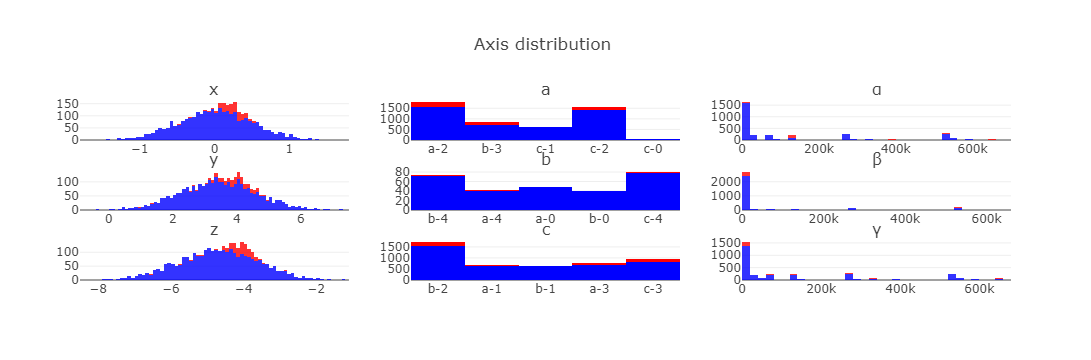

In [37]:
df_name = ""
plot_axis_all(df_read, df_ColGroup_pc1, df_cus)

In [ ]:
plot_comparsion_all(df_cus)

## <span style='color:DarkOliveGreen'>PCA column group check<span style='color:DarkOliveGreen'>

In [117]:
bool_plot = True
dict_df = {}
# sep, feat = [s*n_per_col for s in range(0, 4)], [chr(c) for c in range(97, 100)]
select_seq, select_sort, select_encode = cal_list_sum, sort_LargeToSmall, encode_category

In [118]:
feat =['α','β','γ']
sep,sum_ = [0],0
for s in pca_cg['n_cols']:
    sum_ += s
    sep.append(sum_)  

### (1). PC-F

In [182]:
%%capture
# df_binary = df_bin_pcaFA.copy()
select_group = "PCA_Font_Abs"
df_binary = df_bin_pca_FA.copy()
df_pcaFA = perform_encoding(df_binary, select_seq, select_encode, select_sort, sep_list = sep, new_col_name = feat)
if bool_plot: plot_comparsion_all(df_read, df_binary,df_pcaFA, d_select=d_select_FA, sep = sep, pca= pca) 


select_group = "PCA_Font_WT."
df_binary = df_bin_pca_FW.copy()
df_pcaFW = perform_encoding(df_binary, select_seq, select_encode, select_sort, sep_list = sep, new_col_name = feat)
if bool_plot: plot_comparsion_all(df_read,df_binary ,df_pcaFW, d_select=d_select_FW, sep = sep, pca= pca) 

### (2). PC-B

In [36]:
%%capture
df_binary = df_bin_pc_Ba.copy()
select_group = f"PC_B_abs"
df_pc_b_a = perform_encoding(df_binary.copy(), select_seq, select_encode, select_sort, sep_list = sep, new_col_name = feat)
if bool_plot: plot_comparsion_all(df_pc_b_a, sep = sep) 

df_binary = df_bin_pc_B.copy()
select_group = f"PC_B"
df_pc_b = perform_encoding(df_binary.copy(), select_seq, select_encode, select_sort, sep_list = sep, new_col_name = feat)
if bool_plot: plot_comparsion_all(df_pc_b, sep = sep) 

### (4). RND

In [40]:
%%capture
df_binary = df_br.copy()
select_seq, select_sort, select_encode = cal_list_Rnd, sort_LargeToSmall, encode_category
select_group = "RND"
df_rnd = perform_encoding(df_binary.copy(), select_seq, select_encode, select_sort, sep_list = sep, new_col_name = feat)
if bool_plot: plot_comparsion_all(df_rnd) 


### (5). RND col drop

In [88]:
random.seed(1224)
randomlist = random.sample(range(0,3*sliced_part), 3*sliced_part - (n_per_col*n_pc))
df_rnd_drop = df_bin.copy().drop(df_bin.columns[randomlist], axis=1)

In [89]:
%%capture
select_group = "xyz"
df_binary = df_rnd_drop.copy()

select_seq, select_sort, select_encode = cal_list_Rnd, sort_LargeToSmall, encode_category
df_rnd_col_drop = perform_encoding(df_binary.copy(), select_seq, select_encode, select_sort)
if bool_plot: plot_comparsion_all(df_rnd_col_drop) 

KeyboardInterrupt: 

### save all df

In [864]:
# save dfs to dict_df
dict_df = {
    "Original Cont.":df_r,
    "Bianry":df_bin,
    # "Bin_PC_F":df_pc_f,
    # "Bin_PC_B":df_pc_b,
    "PC_F abs":df_pc_f_a,
    "PC_F":df_pc_f,
    
    "PC_B abs":df_pc_b_a,
    "PC_B":df_pc_b,
    # f"PC {3*sliced_part}":df_pcl1_encode,   
    
    "Rnd":df_rnd,
    # "Rnd_Col drop":df_rnd_col_drop,
}

In [865]:
for df in dict_df:
    print(df, dict_df[df].drop_duplicates().shape)

Original Cont. (3300, 4)
Bianry (3087, 166)
PC_F abs (3087, 4)
PC_F (3087, 4)
PC_B abs (3087, 4)
PC_B (3087, 4)
Rnd (3087, 4)


## <span style='color:purple'>GA<span style='color:DarkOliveGreen'>

### &emsp;&emsp; * <span style='color:white'>fun<span style='color:white'>

####  &emsp;  &emsp; -GA

#####  &emsp;  &emsp;  &emsp; &emsp;  --record, crossover, mutation

In [160]:
### record 
def on_generation(ga):
    print("Generation", ga.generations_completed)
    print(ga.population)
    
def on_fitness(ga, population_fitness):
    avg = sum(ga.last_generation_fitness)/len(ga.last_generation_fitness)
    maximul = max(ga.last_generation_fitness)
    ft_iteration_avg.append(avg)
    ft_iteration_best.append(maximul)
    if ft_so_far_the_best:
        if max(ft_so_far_the_best)<=maximul:ft_so_far_the_best.append(maximul)
        else:ft_so_far_the_best.append(ft_so_far_the_best[-1])
    else:ft_so_far_the_best.append(maximul)
    
### crossover
def order_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pt = sorted(sample(p1,2))
        p1_ele = [p1[e] for e in range(cut_pt[0],cut_pt[1]+1)]
        p2_ele = [p for p in p2 if p not in p1_ele]

        offspring.append(p2_ele[0:cut_pt[0]]+p1_ele+p2_ele[cut_pt[0]:])
        idx += 1
    return np.array(offspring)

def position_based_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pts = sorted(sample(p1,sample(p1,1)[0]))
        p1_ele = [p1[e] for e in cut_pts]
        p2_ele = [p for p in p2 if p not in p1_ele]
        
        c,e=[],0
        for i in cut_pts:
            c,e = p2_ele.insert(i,p1_ele[e]),e+1
            
        offspring.append(p2_ele)
        idx += 1

    return np.array(offspring)

### mutation
def swap_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        mut_pt = sorted(sample(c,2))
        c[mut_pt[0]], c[mut_pt[1]] = c[mut_pt[1]], c[mut_pt[0]]
        offspring[chromosome_idx] = np.array(c)
    return offspring

def scramble_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        cut_pt = sorted(sample(c,2))
        scrable_ele = c[cut_pt[0]:cut_pt[1]+1]
        offspring[chromosome_idx] = np.array(c[0:cut_pt[0]]+sample(scrable_ele,len(scrable_ele))+c[cut_pt[1]+1:])
    return offspring

#####  &emsp;  &emsp;  &emsp; &emsp;  --fittness

In [161]:
gd_fit.sep

[0, 9, 18, 27]

In [162]:
# fittness
def min_type1_dis_fitness(solution, solution_idx): # need df_1 and l_col
    # ori_data = ori_data
    df = gd_fit.df_group
    sep = gd_fit.sep
    n_oreder = [df.columns[:-1].tolist()[i] for i in solution]
    df_order,n_data,total_mse = df.loc[df.GB==1].copy()[n_oreder], [], 0
    for r in range(0,len(df_order)):
        n_r = []
        for i, s in enumerate (sep[:-1]): n_r.append(encode_category(df_order.iloc[r,s:sep[i+1]]))
        n_data.append(n_r)    
    df_encode = pd.DataFrame(n_data)
    
    for c in df_encode.columns:
        l = list(df_encode[c])
        total_mse += -mean_squared_error(l, [sum(l)/len(l)]*len(l))
    return total_mse

def max_ssb_ssw_fitness(solution, solution_idx):
    # ori_data = ori_data
    df = gdf.df_bin
    n_oreder = [df.columns[:-1].tolist()[i] for i in solution]
    df_order_0, df_order_1 = df.loc[df.GB==0].copy()[n_oreder], df.loc[df.GB==1].copy()[n_oreder]    
    X,Y,total_error = [],[],0
    for r in range(0,len(df_order_0)):
        n_r = []
        for i, s in enumerate (gdf.sep[:-1]): n_r.append(encode_category(df_order_0.iloc[r,s:ds.sep[i+1]]))
        X.append(n_r) 
    for r in range(0,len(df_order_1)):
        n_r = []
        for i, s in enumerate (gdf.sep[:-1]): n_r.append(encode_category(df_1_new.iloc[r,s:ds.sep[i+1]]))
        Y.append(n_r)
        
    df_encode_0, df_encode_1 = pd.DataFrame(X),pd.DataFrame(Y)  
    for c in df_new_encode.columns:
        X,Y = list(df_encode_0[c]),list(df_encode_1[c])
        SST, SSE = sum([(t - np.mean(X+Y))**2 for t in X+Y]), sum([(x - np.mean(X))**2 for x in X])+sum([(y - np.mean(Y))**2 for y in Y])
        total_error += (SST-SSE) # += SSB
    return total_error

####  &emsp;  &emsp; -plot

In [163]:
def plot_GA_evolve(ft_iteration_best,ft_so_far_the_best,ft_iteration_avg):
    # Create traces
    x = [i for i in range(1,num_generations+1)]
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=x, y=ft_iteration_best,mode='lines',name='iteration the best',marker_color='blue'))
    fig.add_trace(go.Scatter(x=x, y=ft_so_far_the_best,mode='lines',name='so far the best',marker_color='red'))
    fig.add_trace(go.Scatter(x=x, y=ft_iteration_avg,mode='lines', name='iteration average',marker_color='green'))
    fig.update_layout(title="Binary column permutation",xaxis_title="Generation",yaxis_title="Fitness",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

In [164]:
def arrange_col_by_order(df_bin, order):
    n_data = []
    n_oreder = list(order)
    df_new = df_bin.copy()[n_oreder]
    for r in range(0,len(df_bin)):
        n_data.append(encode_category(df_new.iloc[r,:]))
    df_new = pd.DataFrame(n_data)
    df_new["GB"] = df_bin.GB
    return df_new

def get_cumulated_points(df):
    ordered_dict = collections.OrderedDict(sorted(Counter(df[0]).items()))
    x,y = [],[]
    cum = 0
    for c in ordered_dict:
        cum+=ordered_dict[c]
        x.append(c)
        y.append(cum)
    new_y = []
    for o in y:
        if o and max(y)!=0: new_y.append(o/max(y))
        else:new_y.append(0)
    return x,new_y

def plot_encode_axis(df, name):
    fig = make_subplots(rows=2, cols=1, shared_xaxes='all')#, column_widths=[0.7, 0.3])
    df_1 = df.loc[df.GB==1]
    df_0 = df.loc[df.GB==0]
    x1,y1 = get_cumulated_points(df_1)
    x0,y0 = get_cumulated_points(df_0)
    fig.add_trace(go.Scatter(x=df_0[0],y=len(df_0)*[f"GB=0"],
        mode='markers',marker_color='blue',name=f"GB=0, [{len(df_0)}]",),row=1, col=1)

    fig.add_trace(go.Scatter(x=df_1[0],y=len(df_1)*["GB=1"],
        mode='markers',marker_color='red',name=f"GB=1, [{len(df_1)}]",),row=1, col=1)
    
    fig.add_trace(go.Scatter(x=x1, y=y1,mode='lines',marker_color='red',name='cum 1'),row=2, col=1)
    fig.add_trace(go.Scatter(x=x0, y=y0,mode='lines',marker_color='blue',name='cum 2'),row=2, col=1)
    
    for trace in fig['data']: 
        if("cum" in trace['name']): trace['showlegend'] = False
    fig.update_layout(title=f"Encoding result, {name}",xaxis2_title="Categorical variable",#yaxis_title="Type",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

####  &emsp;  &emsp; -Class

In [165]:
class GA_encoder(seq_encoder):
    # 建構式
    def __init__(self,Grouped_Data, name):
        self.name = name
        self.gd = Grouped_Data
        self.df_group = Grouped_Data.df_group.copy()
        self.df_group_ori = Grouped_Data.df_group_ori
        self.sep = self.gd.sep
    # 方法(Method)
    def bulid_ga(self, sol_per_pop = 10, num_generations = 30,parent_selection_type = "sss",
                 crossover_probability=0.8,mutation_probability = 0.2,fitness_func=min_type1_dis_fitness):
        # get gene space 
        gene_space,s = [],[]
        for i in range(0, self.sep[-1]+1):
            s.append(i)
            if i+1 in self.sep:
                [gene_space.append(s) for _ in range(0,len(s))]
                s = []
        num_genes = len(self.df_group.columns[:-1])
        # ga settings
        ga_instance = pygad.GA(
            num_generations=num_generations,
            sol_per_pop=sol_per_pop,
            num_genes=num_genes,
            init_range_low=0,
            init_range_high=num_genes,

            parent_selection_type=parent_selection_type,

            # crossover_type=crossover_type,
            crossover_probability=crossover_probability,

            # mutation_type=mutation_type,
            mutation_probability = mutation_probability,

            num_parents_mating=2,
            fitness_func=fitness_func,

            gene_type=int,
            gene_space=gene_space,
            # on_generation = self.on_generation,
            on_fitness = on_fitness,
            allow_duplicate_genes=False,
            )
        self.ga = ga_instance
        self.best_sol = [self.df_group.columns[:-1].tolist()[i] for i in list(self.ga.best_solution()[0])]
        
    def run_ga(self):
        self.ga.run()
        # return self.ga.plot_result()
    
    def set_evole_record(self, ft_iteration_avg, ft_iteration_best,ft_so_far_the_best):
        self.ft_iteration_avg = ft_iteration_avg
        self.ft_iteration_best = ft_iteration_best
        self.ft_so_far_the_best = ft_so_far_the_best
        
    def plot_evole(self):
        # Create traces
        x = [i for i in range(1,self.ga.num_generations+1)]
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=self.ft_iteration_best,
                            mode='lines',name='iteration the best',marker_color='blue'))
        fig.add_trace(go.Scatter(x=x, y=self.ft_so_far_the_best,
                            mode='lines',name='so far the best',marker_color='red'))
        fig.add_trace(go.Scatter(x=x, y=self.ft_iteration_avg,
                            mode='lines', name='iteration average',marker_color='green'))
        fig.update_layout(title="Binary column permutation",xaxis_title="Generation",yaxis_title="Fitness",
                          legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
        return fig
    def encode_categorical(self):
        n_oreder, new_data = self.best_sol,[]
        df_swap = self.df_group.copy()[n_oreder]
        for r in df_swap.T:
            row_data = []
            l = self.sep[0]
            for i in self.sep[1:]:
                row_data.append(encode_category(df_swap.iloc[r,l:i]))
                l = i
            new_data.append(row_data)
        df_new = pd.DataFrame(new_data)
        df_new.columns = [self.df_group.columns[i].split('-')[0] for i in self.sep[:-1]]
        df_new["GB"] = self.df_group.GB
        self.df_encode_cate = df_new
        return df_new

### &emsp;| (1) build GA model

In [132]:
# Dataframe para
# df = ds_bin_xyz.df

gd_fit  = gd_xyz
ft_iteration_avg, ft_iteration_best, ft_so_far_the_best=[],[],[]

In [133]:
ga_xyz = GA_encoder(ds,"GA")

In [134]:
ga_xyz.bulid_ga(sol_per_pop=10, num_generations=50,)
ga_xyz.run_ga()

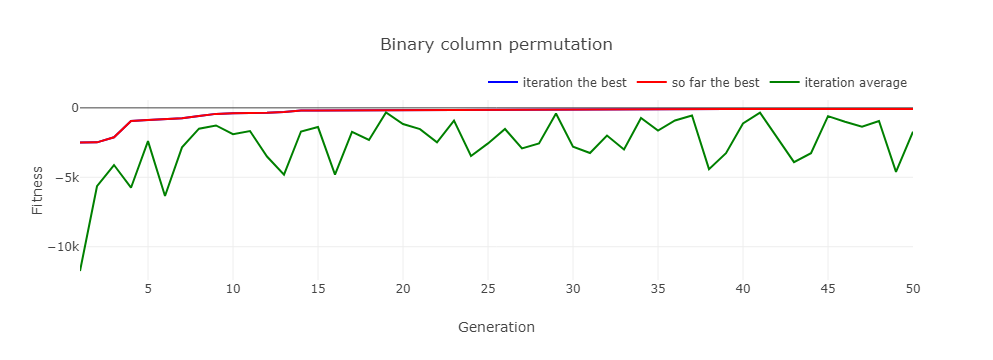

In [135]:
ga_xyz.set_evole_record(ft_iteration_avg,ft_iteration_best,ft_so_far_the_best)
ga_xyz.plot_evole()

In [136]:
fig.write_html(r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\GA evovle.html")

In [137]:
sol = [i for i in range(0,len(ds.df_bin.columns[:-1]))]
sol

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

In [102]:
min_type1_dis_fitness(sol,_)

-28.47599020145188

In [113]:
max_ssb_ssw_fitness(sol,_)

4662.841899992229

In [109]:
total_error = 0
for c in df_new_encode.columns:
    X,Y = list(df_0_new_encode[c]),list(df_1_new_encode[c])
    SST, SSE = sum([(t - np.mean(X+Y))**2 for t in X+Y]), sum([(x - np.mean(X))**2 for x in X])+sum([(y - np.mean(Y))**2 for y in Y])
    SSB = SST-SSE
    total_error += SSB
return total_error

### &emsp;| (2) encoding result

In [396]:
ga_xyz.encode_categorical()

z  y  x  GB
0     1  2  1   0
1     2  2  1   0
2     1  2  1   0
3     2  2  1   0
4     2  2  1   0
...  .. .. ..  ..
3295  1  2  1   1
3296  1  2  1   1
3297  1  2  1   1
3298  1  2  1   1
3299  1  2  1   1

[3300 rows x 4 columns]

In [397]:
out_put_path = r"C:\Users\User\Desktop\Terry\Data\Output"
plot_comparsion_all_new(df_read, df_bin, ga_xyz.encode_categorical(), dr_name = "GA",sep=ga_xyz.Dataset.sep)

<_io.TextIOWrapper name="C:\\Users\\User\\Desktop\\Terry\\Data\\Output/['GA'].html" mode='a' encoding='cp1252'>

In [407]:
plot_compare_all(ds_data, ga_xyz, dr_name = "GA")

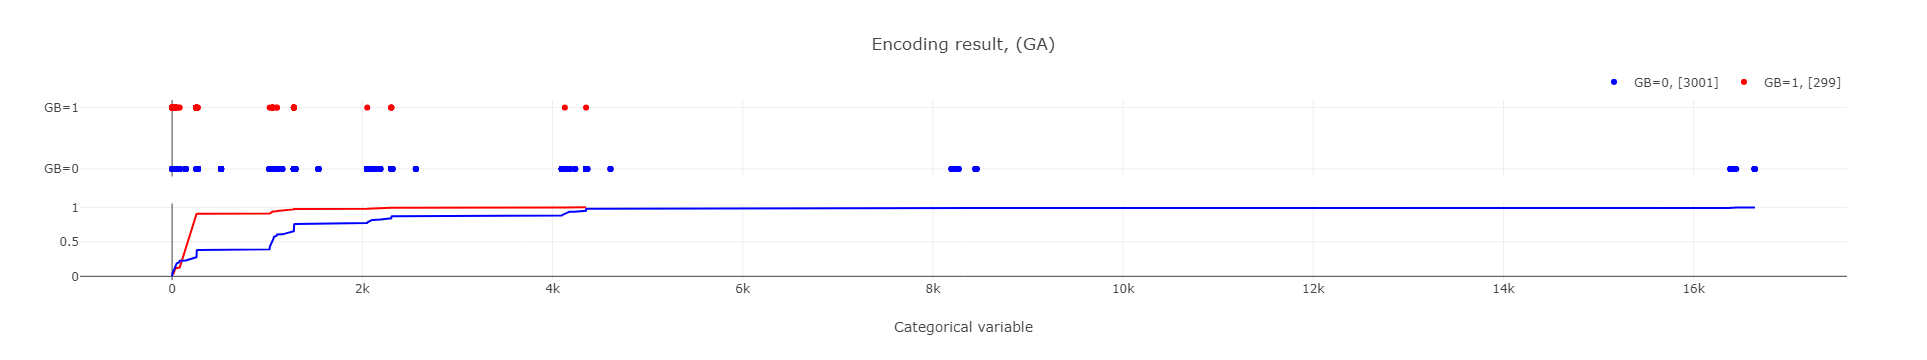

In [379]:
df_ga = arrange_col_by_order(df_bin,[l_col[i] for i in list(ga_xyz.ga.best_solution()[0])])
plot_encode_axis(df_ga, "(GA)")

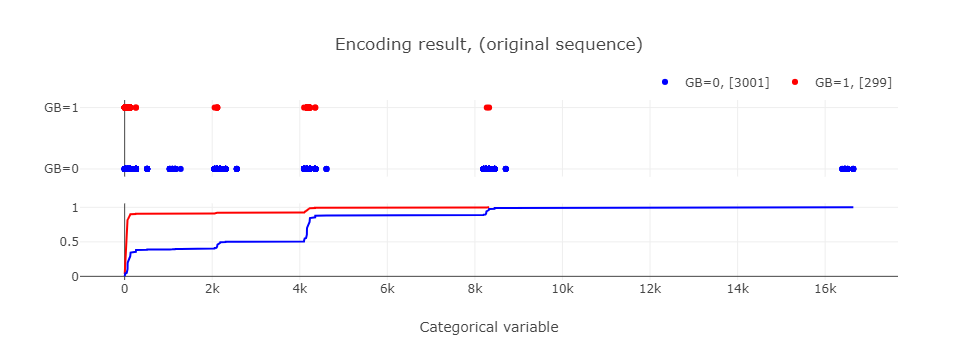

In [378]:
df_ori = arrange_col_by_order(df_bin,df_bin.columns[:-1])
plot_encode_axis(df_ori, "(original sequence)")# df_new

## <span style='color:brown'>Defult class<span style='color:brown'>

In [67]:
def plot_encode_axis(encoder):
    fig = make_subplots(rows=2, cols=2, shared_xaxes='columns')#, column_widths=[0.7, 0.3])
    df_c,df_g = encoder.encode_categorical(),encoder.rerange_grid()
    for i, tp in enumerate( [df_c,df_g]):
        df = tp
        df_1 = df.loc[df.GB==1]
        df_0 = df.loc[df.GB==0]
        x1,y1 = get_cumulated_points(df_1)
        x0,y0 = get_cumulated_points(df_0)

        fig.add_trace(go.Scatter(x=df_0[df.columns[0]],y=len(df_0)*[f"GB=0"],mode='markers', marker=dict(color="blue"),
                                 name=f"GB=0, [{len(df_0)}]",),row=1, col=i+1)
        fig.add_trace(go.Scatter(x=df_1[df.columns[0]],y=len(df_1)*["GB=1"],mode='markers', marker=dict(color="red"),
                                 name=f"GB=1, [{len(df_1)}]",),row=1, col=i+1)

        fig.add_trace(go.Scatter(x=x1, y=y1,mode='lines',marker_color='red',name='cum 1')
                      ,row=2, col=i+1)
        fig.add_trace(go.Scatter(x=x0, y=y0,mode='lines',marker_color='blue',name='cum 2')
                      ,row=2, col=i+1)

        for trace in fig['data']: trace['showlegend'] = False
            # if("cum" in trace['name']): trace['showlegend'] = False
    fig.update_layout(title=f"Rearrange comparison",xaxis3_title="Categorical",xaxis4_title="Rearrange-grid",)#yaxis_title="Type",)
                      # legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

In [68]:
def overlap_transform(X_train,y_train):
    X_train,y_train =x,y
    df, col_name, = X_train.copy(), y_train.copy().columns[-1]
    df[col_name]= y_train.copy()
    df_type1 = df.loc[df[col_name] == 1].drop_duplicates().drop(columns=[col_name],)
    new_y_train,l = [],[list(row) for row in df_type1.values]
    for row in X_train.values:
        if list(row) in l:new_y_train.append(1)
        else: new_y_train.append(0)
    return pd.DataFrame(data=new_y_train, columns=[col_name], index = y_train.index)

### (1). rnd

In [69]:
rnd_encoder = seq_encoder(gd_rnd, "rnd")
rnd_encoder.set_encode_funs(seq_rnd,sort_LargeToSmall,encode_category)
# rnd_encoder.encode_categorical()

In [70]:
# rnd_encoder.encode_categorical()
rnd_encoder.encode_grid()

In [71]:
plot_encode_axis(rnd_encoder)

AttributeError: 'seq_encoder' object has no attribute 'rerange_grid'

### (2). sum

In [72]:
sum_encoder = seq_encoder(gd_xyz, "sum")
sum_encoder.set_encode_funs(seq_sum,sort_LargeToSmall,encode_category)
sum_encoder.encode_grid()

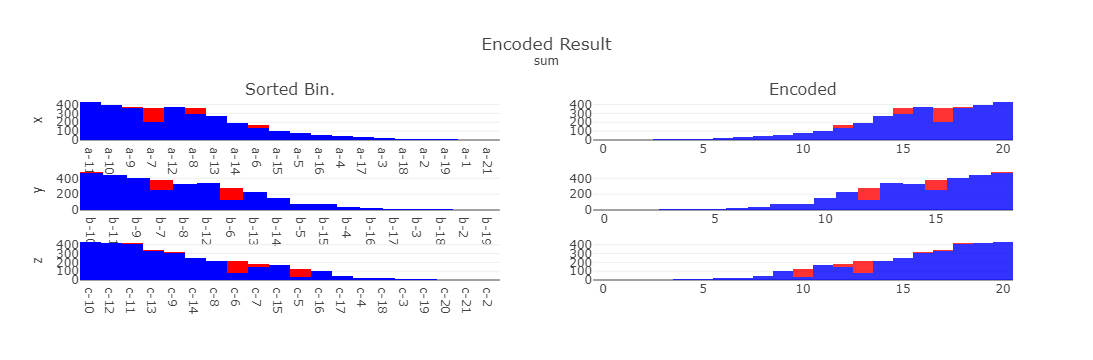

In [73]:
plot_encoded_axis(sum_encoder,sum_encoder.df_grid)

In [102]:
# out_put_path = r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig"
plot_compare_all(ori_data,gd_rnd,sum_encoder,sum_encoder.df_grid_train)

"C:\\Users\\User\\Desktop\\Terry\\Data\\Output\\3D Fig/['99', 'sum'].html"

### (3). ground truth

In [185]:
gt_encoder = seq_encoder(gd_xyz, "ID")
gt_encoder.set_encode_funs(seq_ID,sort_SmallToLarge,encode_category)
gt_encoder.encode_grid()

In [186]:
plot_compare_all(ori_data,gd_xyz,gt_encoder,gt_encoder.df_grid)

"C:\\Users\\User\\Desktop\\Terry\\Data\\Output\\3D Fig/['99', 'ID'].html"

### (4). Gini value

In [194]:
gi_encoder = seq_encoder(gd_xyz,"gini")
gi_encoder.set_encode_funs(seq_ratio,sort_SmallToLarge,encode_category)
gi_encoder.encode_grid()

In [195]:
plot_compare_all(ori_data,gd_xyz,gi_encoder,gi_encoder.df_grid)

"C:\\Users\\User\\Desktop\\Terry\\Data\\Output\\3D Fig/['99', 'gini'].html"

# **4. Classification results**
---

### functions

In [45]:
from sklearn.model_selection import train_test_split
from ipywidgets import Layout
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

#### -ui

In [46]:
### UI event
gbm_metric = "average_precision"
gbm_boost_type = "gbdt"
gbm_feval = True
gbm_round = 500
def rb_event_gbm_metric(sender):
    global gbm_metric   
    gbm_metric = rb_gbm_metric.value
def rb_event_gbm_boost_type(sender):
    global gbm_boost_type   
    gbm_boost_type = rb_gbm_boost_type.value  
def rb_event_gbm_feval(sender):
    global gbm_feval   
    tp = rb_gbm_feval.value
    if tp == "on":
        gbm_feval = True
    elif tp == "off":
        gbm_feval = False

In [47]:
### UI outlook
rb_gbm_boost_type = widgets.RadioButtons(
    options=["gbdt", "dart", "rf","goss"],
    layout={'width': 'max-content'},
)
rb_gbm_metric = widgets.RadioButtons(
    options=["average_precision", "auc", "rmse","binary_logloss","None"],
    layout={'width': 'max-content'},
)
rb_gbm_feval = widgets.RadioButtons(
    options=["on", "off"],
    layout={'width': 'max-content'},
)
sd_gbm_fbeta = widgets.FloatSlider(value = 0.5, min = 0.0, max = 1.0, step = 0.1,description='',layout=Layout(width='200px'))
sd_gbm_round = widgets.IntSlider(value = 300, min = 100, max = 1000, step = 100,description='',layout=Layout(width='300px'))
rb_gbm_boost_type.observe(rb_event_gbm_boost_type, names=['value'])
rb_gbm_metric.observe(rb_event_gbm_metric, names=['value'])
rb_gbm_feval.observe(rb_event_gbm_feval, names=['value'])

#### -feval functions

In [48]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

feval_fun = None
def lgb_fbeta_score(y_hat, data):
    beta_value=sd_gbm_fbeta.value
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return f'f {beta_value} ', fbeta_score(y_true, y_hat, beta = beta_value), True

def lgb_recall_score(y_hat, data):
    beta_value=sd_gbm_fbeta.value
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return f'f {beta_value} ', recall_score(y_true, y_hat), True


#### -classification

In [49]:
def matrix_reflection(m):
    tl,tr = m[0][0], m[1][0]
    dl,dr = m[0][1],m[1][1]
    n = np.array([[dr, dl],[tr, tl]])
    return n

def recall_precision_n(m):
    tp,fp = m[0][0], m[1][0]
    fn,tn = m[0][1],m[1][1]
    a = (tp+tn)/(tp+fp+fn+tn)
    p = np.sum(tp / (tp + fn))
    r = np.sum(tp / (tp + fp))
    f = (2 * p * r) / (r + p)
    return  dict(recall = r, precision = p, f1_score = f)

In [50]:
def overlap_transform(X_train,y_train):
    # X_train,y_train =x,y
    df, col_name, = X_train.copy(), y_train.copy().columns[-1]
    df[col_name]= y_train.copy()
    df_type1 = df.loc[df[col_name] == 1].drop_duplicates().drop(columns=[col_name],)
    new_y_train,l = [],[list(row) for row in df_type1.values]
    for row in X_train.values:
        if list(row) in l:new_y_train.append(1)
        else: new_y_train.append(0)
    return pd.DataFrame(data=new_y_train, columns=[col_name], index = y_train.index)

In [51]:
def cal_all_dfs(dict_train, dict_test):
    dict_cm,dict_eval,dict_clf = {},{},{}
    df_all = pd.DataFrame()
    for name_df in dict_train:
        s, dict_cm[name_df], dict_eval[name_df], dict_clf[name_df] = pre_and_cal_score(dict_train[name_df], dict_test[name_df])
        df_m = pd.DataFrame.from_dict(s, orient='index')
        df_m.columns = [name_df]
        df_all = pd.concat([df_all, df_m], axis=1)
    return df_all, dict_clf, dict_eval, dict_cm

def pre_and_cal_score(df_train, df_test): 
    X_train, y_train = df_train.iloc[:,:-1], df_train.iloc[:,-1:]
    X_test, y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1:]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1224, train_size = .75,stratify=y,)
    # overlap trasform
    y_train = overlap_transform(X_train,y_train)
    
    cm, evals_result, clf = light_gbm(X_train, X_test, y_train, y_test)
    cm_r = matrix_reflection(cm)
    # cm_r = cm
    return recall_precision_n(cm_r), cm_r, evals_result, clf

def light_gbm(X_train, X_test, y_train, y_test):
    lgb_train = lgb.Dataset(data=X_train,label=y_train)
    lgb_test = lgb.Dataset(data=X_test,label=y_test)

    evals_result = {} 
    clf = lgb.train(
        params = params,
        train_set = lgb_train, 
        num_boost_round = gbm_round,
        valid_sets = [lgb_train, lgb_test], 
        valid_names = ["Train", "Validation"], 
        evals_result = evals_result, 
        early_stopping_rounds = None,
        feval=feval_fun,
    )
    # prediction on test data
    y_pred_lgbm = clf.predict(X_test, num_iteration = clf.best_iteration)
    # convert into binary values
    for i in range(0, X_test.shape[0]):
        if y_pred_lgbm[i] > .5:y_pred_lgbm[i] = 1
        else:y_pred_lgbm[i] = 0
    # output confusion matris
    cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
    return cm_lgbm, evals_result, clf



#### -plot

In [52]:
def plot_heatmap_all(dict_cm):
    fig,ax=plt.subplots(1,len(dict_cm),figsize=(5*len(dict_cm), 5))

    # target = ['Ori','Mach','Mach_LS','Mach_SL','Cham','Cham_LS','Cham_SL']
    tick = ["GB=1","GB=0"]
    # for index, i in enumerate(target):
    x = 0
    for i in dict_cm:
        cm = dict_cm[i]
        sns.set(font_scale=1.8)
        sns.heatmap(cm, annot = True,xticklabels=tick,yticklabels=tick, fmt="", cbar=False,ax = ax[x])
        #, rc={'axes.facecolor':color, 'figure.facecolor':color} )
        ax[x].set_title(i)
        ax[x].get_xaxis().set_visible(True)
        if x != 0:
            ax[x].get_yaxis().set_visible(False)
        x = x+1
    p = [n for n in df_name.split('/')]
    plt.suptitle(f"{p[0]}, {p[1]}", fontsize=30, y = 1.1)
    return fig
    
def plot_learning_curve_all(dict_eval, metric=None):
    fig,ax=plt.subplots(1,len(dict_eval),figsize=(5*len(dict_eval), 5))
    # for index, i in enumerate(target):
    x = 0
    for i in dict_eval:
        lgb.plot_metric(dict_eval[i], title = i, ax = ax[x], metric = metric)
        ax[x].get_legend().remove()
        x = x+1
    x = 0
    lines = []
    labels = []
    axLine, axLabel = ax[0].get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)   
    fig.legend(lines, labels, loc = "upper left", ncol=len(dict_eval))
    fig.tight_layout()
    p = [n for n in df_name.split('/')]
    plt.suptitle(f"{p[0]}, {p[1]}", fontsize=30, y = 1.1)
    return fig

In [53]:
def plot_class_score(df_data):
    global df_name
    df_name = f"{shp_name} / Binary Features: {n_bin_col}"
    df = df_data.T.copy()
    fig = go.Figure()
    
    for col in df.columns:
        fig.add_trace(go.Bar(x=df.index,y=df[col],name=col,opacity=0.8))
    fig.update_layout(
        title_text=f'LightGBM Classification result <br><sup> {df_name} </sup> ', # title of plot
        yaxis_title_text='score', # yaxis label
        barmode='group',
        legend_tracegroupgap = 180,
        bargap=0.3, # gap between bars of adjacent location coordinates
        bargroupgap=0.1, # gap between bars of the same location coordinates      
        height=500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    return fig

def plot_class_cm(dict_cm):
    fig = make_subplots(rows=1, cols=len(dict_cm),subplot_titles=(list(dict_cm.keys())))
    for i in range(0,len(dict_cm)):
        cm = dict_cm[list(dict_cm.keys())[i]]
        heatmap = go.Heatmap(x = ["GB = 1","GB = 0"],y = ["GB = 1","GB = 0"], z = cm, 
                             text=cm, texttemplate="%{text}",textfont={"size":10},
                             showscale=False,xgap=3, ygap=3,colorscale='RdBu')
        fig.add_trace(heatmap,row=1, col=i+1)

    fig.update_yaxes(showgrid=False,showticklabels=False,autorange='reversed')
    fig['layout']['yaxis'].update(showgrid=False,showticklabels=True,autorange='reversed')
    fig.update_xaxes(showgrid=False,showticklabels=True)    
    fig.update_layout(title = "Confusion Matrix", showlegend=True,height=300,
                      # margin=go.layout.Margin(t=30,)
                     )
    return fig

def plot_class_score_table(df_data):
    # df = df_data.copy().applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,3)))
    df = df_data.copy()
    s_color = ['blue', 'orange', 'green']
    fig = go.Figure(data=[go.Table(ids=df.index,
    header=dict(values = df.columns.tolist()
                ,fill_color='cornflowerblue',align='center',
                font=dict(color='white',size=15)),
    cells=dict(values = [df[c].values for c in df.columns]
               ,fill_color='ivory',align='center'
               ,font=dict(size=12, color = [s_color*len(df.columns)])))])
    fig.update_layout(height = 130,
                      margin=go.layout.Margin(t=0, b=0)
                      )
    return fig

def plot_class_all(df_all, dict_cm, bc):
    global n_bin_col
    n_bin_col = bc-3
    fig_sc = plot_class_score(df_all.copy())
    fig_cm = plot_class_cm(dict_cm.copy())
    fig_tb = plot_class_score_table(df_all.copy())
    # output fig, create path if not exist
    if not os.path.exists(out_put_path): os.makedirs(out_put_path)
    # check output name, delete file if exist
    p = [f"{n_bin_col}","Classification results"]
    if os.path.exists(f"{out_put_path}/{p}.html"): os.remove(f"{out_put_path}/{p}.html")
    # df_name = f"{shp_name} / SP {sliced_part} / {select_group} /{m_name}"
    with open(f"{out_put_path}/{p}.html", 'a') as f:
        f.write(fig_sc.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_tb.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_cm.to_html(full_html=False, include_plotlyjs='cdn'))

## i. params settings

In [54]:
vb_metiric = VBox([Button(description="metric"), rb_gbm_metric])
vb_boost_type = VBox([Button(description="boost type"), rb_gbm_boost_type])
vb_feval = VBox([Button(description="feval",layout=Layout(width='200px')), rb_gbm_feval,Button(description="beta",layout=Layout(width='200px')),sd_gbm_fbeta])
vb_boost_round=VBox([Button(description="boosting rounds",layout=Layout(width='300px')), sd_gbm_round])

display(HBox([vb_boost_type,vb_metiric, vb_feval,vb_boost_round]))

In [55]:
params = {
        "objective": "binary",
        "metric": gbm_metric,
        # "feval":lgb_recall_score,
        "verbosity": -1,
        "boosting_type": gbm_boost_type,                
        "seed": 1224,
    }
if gbm_feval: feval_fun = lgb_recall_score
gbm_round =  sd_gbm_round.value

In [94]:
X_train = ori_data.df_train.iloc[:,:-1]
y_train = ori_data.df_train.iloc[:,-1:]
X_test = ori_data.df_test.iloc[:,:-1]
y_test = ori_data.df_test.iloc[:,-1:]

In [43]:
%%capture
lgb_train = lgb.Dataset(data=X_train,label=y_train)
lgb_test = lgb.Dataset(data=X_test,label=y_test)

evals_result = {} 
clf = lgb.train(
    params = params,
    train_set = lgb_train, 
    num_boost_round = gbm_round,
    valid_sets = [lgb_train, lgb_test], 
    valid_names = ["Train", "Validation"], 
    evals_result = evals_result, 
    early_stopping_rounds = None,
    feval=feval_fun,
)
# prediction on test data
y_pred_lgbm = clf.predict(X_test, num_iteration = clf.best_iteration)
# convert into binary values
for i in range(0, X_test.shape[0]):
    if y_pred_lgbm[i] > .5:y_pred_lgbm[i] = 1
    else:y_pred_lgbm[i] = 0
# output confusion matris
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

## ii. classify by lightgbm

In [206]:
df_train,df_test = dict_train["Bin"],dict_test["Bin"]
X_train, y_train = df_train.iloc[:,:-1], df_train.iloc[:,-1:]
X_test, y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1224, train_size = .75,stratify=y,)
# overlap trasform
y_train = overlap_transform(X_train,y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [89]:
%%capture
df_all, dict_clf, dict_eval, dict_cm =  cal_all_dfs(dict_df)

NameError: name 'dict_df' is not defined

In [308]:
df_all=df_all.fillna(0)
df_all = df_all.applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,3)))
df_all

binary original     GA
recall      0.72     0.72   0.72
precision  0.806    0.806  0.806
f1_score   0.761    0.761  0.761

In [273]:
out_put_path = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\BC"
plot_class_all(df_all, dict_cm)

In [ ]:
df_name = f"{shp_name} / SP {sliced_part}"

if gbm_metric == "None": plot_learning_curve_all(dict_eval).show()
else: plot_learning_curve_all(dict_eval,gbm_metric).show()
plot_heatmap_all(dict_cm).show()

## * different BC test* with GA

In [295]:
%%capture
shp_name = "shape 3"
ori_data = Originl_Data(shp_name)
f1_score, re_score, pre_score = {},{},{}
R = range(30,103,3)
SKFold = 4
for bc in R:
    # 1. read and slice data
    #........................................................
    ori_data.slice_to_bin(bc)
    ori_data.drop_zero_col()
    ori_data.drop_one_col_minsum()
    ori_data.get_sep_and_col()
    ori_data.spilt_SKFold(SKFold)
    fold_f1, fold_re, fold_pre = [],[],[]
    for fold in range(0,SKFold):
        ori_data.set_folds(fold)
        # ori_data.spilt_train_and_test(0.75)
        out_put_path  = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\Bin_Feat - {bc} ({ori_data.bin_feat})\fold {fold+1}"

        # 2. group columns
        #........................................................
        ### xyz
        gd_xyz = Grouped_Data(ori_data,"xyz")
        gd_xyz.set_seq([i for i in range(0,ori_data.bin_feat)])
        gd_xyz.set_col(["x","y","z"])
        gd_xyz.group_df()
        # ### rnd
        # gd_rnd = Grouped_Data(ori_data,"Rnd")
        # gd_rnd.set_seq(random.sample([i for i in range(0, ori_data.bin_feat)],ori_data.bin_feat))
        # gd_rnd.set_col(["r1","r2","r3"])
        # gd_rnd.group_df()
        # ### pca
        # gd_pca = Grouped_Data_PCA(ori_data,"PCA")
        # gd_pca.set_seq()
        # gd_pca.set_col(["pc1","pc2","pc3"])
        # gd_pca.group_df()
        ### corr
        gd_corr = Grouped_Data_Corr(ori_data, "corr")
        gd_corr.set_seq()
        gd_corr.set_col(["c1","c2","c3"])
        gd_corr.group_df()
        
        gd_corrABS = Grouped_Data_Corr_ABS(ori_data, "corr ABS")
        gd_corrABS.set_seq()
        gd_corrABS.set_col(["c1","c2","c3"])
        gd_corrABS.group_df()        
        
        gd_corrSqure = Grouped_Data_Corr_Squre(ori_data, "corr squre")
        gd_corrSqure.set_seq()
        gd_corrSqure.set_col(["c1","c2","c3"])
        gd_corrSqure.group_df()      
        
        dict_gd = {}
        # dict_gd = {"xyz":gd_xyz,"Rnd":gd_rnd,"PCA":gd_pca, "Corr":gd_corr}
        dict_gd = {"xyz":gd_xyz,"Corr":gd_corr, "Corr ABS":gd_corrABS, "Corr Squre":gd_corrSqure}
        # 3. encoding
        #........................................................
        dict_train, dict_test = {}, {}
        dict_train["Bin"], dict_test["Bin"] = ori_data.df_train, ori_data.df_test
        for name_gd in dict_gd:
            paths = []
            group_data = dict_gd[name_gd]
    #         for f in [" "]:#, "SSB, SSE"]: 
    #             ft_iteration_avg, ft_iteration_best, ft_so_far_the_best=[],[],[]

    #             ### GA
    #             gd_fit = gd
    #             ga_encoder = GA_encoder(gd, f"{name_gd} / GA {f}" )
    #             if f ==" ":fitness_func = min_type1_dis_fitness
    #             else :fitness_func = max_ssb_ssw_fitness
    #             ga_encoder.bulid_ga(sol_per_pop=30, num_generations=100,fitness_func = fitness_func)
    #             ga_encoder.run_ga()
    #             ga_encoder.set_evole_record(ft_iteration_avg,ft_iteration_best,ft_so_far_the_best)

    #             path = plot_compare_all(ori_data, ga_encoder, ga_encoder.encode_grid(),ga_encoder.reindex_encoded())
    #             with open(path, 'a') as file:file.write(ga_encoder.plot_evole().to_html(full_html=False, include_plotlyjs='cdn'))
    #             paths.append(path)
    #             dict_df[f"{ga_encoder.name}"] = ga_encoder.reindex_encoded()
    #             # dict_df[f"{ga_encoder.name} / grid"] = ga_encoder.rerange_grid()

            ### ground truth  
            if name_gd =="xyz":
                gt_encoder = seq_encoder(group_data,f"{name_gd} / ID" )
                gt_encoder.set_encode_funs(seq_ID,sort_LargeToSmall,encode_category)       
                gt_encoder.encode_grid()
                paths.append(plot_compare_all(ori_data, group_data, gt_encoder, gt_encoder.df_grid))
                dict_train[f"{gt_encoder.name}"],dict_test[f"{gt_encoder.name}"] = gt_encoder.df_grid_train, gt_encoder.df_grid_test
            ### sum 
            sum_encoder = seq_encoder(group_data,f"{name_gd} / Sum")
            sum_encoder.set_encode_funs(seq_sum,sort_SmallToLarge,encode_category)       
            sum_encoder.encode_grid()
            paths.append(plot_compare_all(ori_data, group_data, sum_encoder, sum_encoder.df_grid))
            dict_train[f"{sum_encoder.name}"],dict_test[f"{sum_encoder.name}"] = sum_encoder.df_grid_train,sum_encoder.df_grid_test

            ### gini
            gi_encoder = seq_encoder(group_data,f"{name_gd} / gini")
            gi_encoder.set_encode_funs(seq_ratio,sort_SmallToLarge,encode_category)
            gi_encoder.encode_grid()
            paths.append(plot_compare_all(ori_data, group_data, gi_encoder, gi_encoder.df_grid))
            dict_train[f"{gi_encoder.name}"],dict_test[f"{gi_encoder.name}"] = gi_encoder.df_grid_train, gi_encoder.df_grid_test

            ### rnd  
            rnd_encoder = seq_encoder(group_data,f"{name_gd} / Rnd" )
            rnd_encoder.set_encode_funs(seq_rnd,sort_LargeToSmall,encode_category) 
            rnd_encoder.encode_grid()
            paths.append(plot_compare_all(ori_data, group_data, rnd_encoder, rnd_encoder.df_grid))
            dict_train[f"{rnd_encoder.name}"],dict_test[f"{rnd_encoder.name}"] = rnd_encoder.df_grid_train,rnd_encoder.df_grid_test

            if name_gd == "PCA": 
                for p in paths:
                    with open(p, 'a') as file:file.write(group_data.plot_pca_group().to_html(full_html=False, include_plotlyjs='cdn'))
            elif name_gd == "Corr": 
                for p in paths:
                    with open(p, 'a') as file:file.write(group_data.plot_corr_group().to_html(full_html=False, include_plotlyjs='cdn'))
    
        # 4. Classification
        #........................................................
        df_all, dict_clf, dict_eval, dict_cm =  cal_all_dfs(dict_train, dict_test)
        df_all=df_all.fillna(0)
        df_all = df_all.applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,4)))
        fold_f1.append(list(np.concatenate(df_all.loc[["f1_score"]].values).flat)) 
        fold_re.append(list(np.concatenate(df_all.loc[["recall"]].values).flat))
        fold_pre.append(list(np.concatenate(df_all.loc[["precision"]].values).flat))
        plot_class_all(df_all, dict_cm, bc)
        
    f1_score[f"bc {bc}"] = np.mean(np.array(fold_f1).astype(np.float) , axis = 0)
    re_score[f"bc {bc}"] = np.mean(np.array(fold_re).astype(np.float) , axis = 0)
    pre_score[f"bc {bc}"] = np.mean(np.array(fold_pre).astype(np.float) , axis = 0)
    out_put_path  = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\Bin_Feat - {bc} ({ori_data.bin_feat})"
    # plot_class_all(df_all, dict_cm, bc)

In [298]:
# output class score
score = re_score
df_class = pd.DataFrame(score).T
df_class.columns = df_all.columns
df_class.index = [idx.split(" ")[1] for idx in list(df_class.index)]
df_class = df_class.round(decimals = 4)
df_class.index.name = "Binary features"
df_class

Bin  xyz / ID  xyz / Sum  xyz / gini  xyz / Rnd  \
Binary features                                                       
30               0.9264    0.6824     0.6598      0.5798     0.4351   
33               0.8897    0.7692     0.7288      0.8023     0.5579   
36               0.8929    0.6029     0.7696      0.7796     0.6429   
39               0.8996    0.6472     0.7319      0.8021     0.5708   
42               0.8694    0.5991     0.3951      0.5087     0.1705   
45               0.8496    0.7228     0.6193      0.5617     0.3371   
48               0.8796    0.6395     0.7619      0.7384     0.3942   
51               0.8494    0.4527     0.4894      0.6061     0.1612   
54               0.8327    0.4640     0.5379      0.4983     0.3033   
57               0.8428    0.5125     0.4746      0.5281     0.3594   
60               0.8394    0.5355     0.4652      0.4652     0.1241   
63               0.7791    0.4081     0.5583      0.4913     0.3648   
66               0.8264    0.2643     0.4954      0.5192     0.3543   
69               0.7892    0.3716     0.3619      0.3883     0.2014   
72               0.7823    0.6192     0.6854      0.6318     0.1949   
75               0.7890    0.3609     0.4985      0.5620     0.1500   
78               0.7691    0.5018     0.3776      0.4539     0.1333   
81               0.7692    0.2802     0.4677      0.5824     0.1433   
84               0.7490    0.3244     0.5248      0.5385     0.1349   
87               0.7226    0.3703     0.4879      0.5924     0.0467   
90               0.7591    0.2968     0.4846      0.5916     0.0667   
93               0.7227    0.3896     0.5824      0.6223     0.4119   
96               0.7457    0.3616     0.5748      0.5050     0.0804   
99               0.7526    0.0907     0.4384      0.5153     0.0702   
102              0.6790    0.4034     0.5481      0.5414     0.0734   

                 Corr / Sum  Corr / gini  Corr / Rnd  Corr ABS / Sum  \
Binary features                                                        
30                   0.8864       0.8797      0.3738          0.6598   
33                   0.8428       0.8629      0.2969          0.7288   
36                   0.8130       0.8259      0.2243          0.8329   
39                   0.8628       0.8963      0.2110          0.8252   
42                   0.8260       0.8194      0.2175          0.7118   
45                   0.7725       0.7363      0.1203          0.7557   
48                   0.7286       0.7484      0.1709          0.8119   
51                   0.7890       0.6853      0.1207          0.8494   
54                   0.6623       0.6588      0.0834          0.8294   
57                   0.7458       0.7324      0.1548          0.8561   
60                   0.6556       0.6323      0.1002          0.8427   
63                   0.5284       0.6047      0.0333          0.7216   
66                   0.6186       0.6757      0.1267          0.8264   
69                   0.4452       0.5950      0.2888          0.7552   
72                   0.5016       0.6851      0.0435          0.7924   
75                   0.5318       0.6620      0.0966          0.6852   
78                   0.3509       0.4805      0.0500          0.5176   
81                   0.4880       0.5182      0.2207          0.5961   
84                   0.4348       0.5552      0.1979          0.6281   
87                   0.5351       0.6693      0.0537          0.6993   
90                   0.4412       0.5783      0.0833          0.5479   
93                   0.5791       0.5856      0.1415          0.6591   
96                   0.6052       0.5687      0.0769          0.6925   
99                   0.4384       0.5153      0.0810          0.4384   
102                  0.5481       0.5414      0.1733          0.5481   

                 Corr ABS / gini  Corr ABS / Rnd  Corr Squre / Sum  \
Binary features                                                      
30               

In [489]:
df = df_class
metric = "recall"
fig_line = plot_class_score_line(df.T, metric)
fig_bar = plot_class_score_bar(df.T, metric)

In [254]:
shp_name = "shape 5"
file_name = "10-4 score.xlsx"
path = rf"C:\Users\User\Desktop\Terry\Data\Datasets\{file_name}"
df_score = pd.read_excel(path,index_col=0,sheet_name = shp_name)
metric = []
n = int(len(df_score.columns)/2)
for i in range(0,2):
    df = df_score.iloc[:,i*n:i*n+n]
    metric.append(df.columns[0])
new_header = df_score.iloc[0] 
df_score = df_score[1:]
df_score.columns = new_header 

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\Desktop\\Terry\\Data\\Datasets\\10-4 score.xlsx'

In [206]:
df_score

Binary Features   \nBin xyz / ID xyz / Sum xyz / gini xyz / Rnd Rnd / Sum  \
30               0.9867   0.9867    0.9867     0.9867    0.9867    0.9867   
33               0.8933   0.8933    0.8933     0.8933    0.8933    0.8933   
36               0.9467   0.7467    0.7867       0.24    0.0133    0.9467   
39               0.8933   0.7333    0.6667     0.6667      0.72    0.8933   
42                 0.84   0.6533      0.68       0.48         0    0.8267   
45               0.8667     0.64      0.88     0.8267    0.0667    0.8667   
48               0.8667   0.6133      0.48     0.4267         0    0.8667   
51               0.8933   0.1733    0.8667       0.84    0.0133    0.8933   
54                  0.8     0.56    0.6667     0.6267         0       0.8   
57                 0.84     0.28    0.8533     0.8533         0      0.84   
60               0.8667   0.6533    0.5333     0.5333         0    0.8667   
63               0.8533   0.8533       0.6       0.76    0.0267    0.8533   
66                 0.88     0.64      0.88       0.88         0      0.84   
69               0.9067      0.2      0.84     0.8533         0    0.9067   
72                 0.88   0.8267    0.8533       0.56      0.88      0.88   
75                 0.84   0.2133    0.4667     0.6667    0.0133    0.8133   
78                 0.84   0.1467    0.5333       0.76         0    0.8533   
81               0.8667     0.24      0.44       0.64    0.1733    0.7467   
84               0.8267   0.0667    0.5333     0.5067         0    0.8267   
87                  0.8     0.52    0.8133     0.8133      0.04       0.8   
90                 0.92     0.76    0.3333     0.5067    0.0533    0.9067   
93               0.8133   0.3467    0.7067     0.8267      0.04    0.8533   
96                 0.88   0.2133      0.52        0.8         0      0.84   
99               0.8267   0.1067    0.7067     0.7867         0    0.7733   
102              0.8133   0.0933    0.8133     0.6667      0.08       0.8   

Binary Features Rnd / gini Rnd / Rnd PCA / Sum PCA / gini  ... xyz / Rnd  \
30                  0.9867      0.08    0.9867     0.9867  ...    0.2691   
33                  0.8933         0    0.8933     0.8933  ...    0.3401   
36                  0.9467         0    0.9333     0.9467  ...    0.0185   
39                  0.8933      0.24    0.8933     0.9333  ...    0.4954   
42                  0.8267      0.04    0.8267       0.84  ...         0   
45                  0.8533    0.5733    0.8667     0.8667  ...     0.125   
48                  0.8667    0.1333    0.8667     0.8667  ...         0   
51                    0.88      0.04    0.8933     0.8933  ...    0.0667   
54                     0.8         0    0.8133        0.8  ...         0   
57                  0.8533         0    0.8533       0.84  ...         0   
60                  0.8667    0.1067      0.84     0.8533  ...         0   
63                    0.84    0.1467       0.8     0.8533  ...     0.125   
66                  0.8533         0    0.8533     0.9067  ...         0   
69                  0.8933         0    0.8933     0.8667  ...         0   
72                    0.88    0.0133    0.7733     0.8267  ...    0.5893   
75                  0.8267         0    0.7733     0.8267  ...    0.1111   
78                  0.8533      0.04    0.8133     0.8667  ...         0   
81                  0.8533    0.0267    0.7867       0.88  ...      0.52   
84                     0.8    0.3867    0.7467     0.7333  ...         0   
87                  0.8133         0    0.8133     0.7867  ...    0.1765   
90                  0.9067    0.1333    0.8667     0.9333  ...    0.2353   
93                    0.84      0.08       0.8     0.8533  ...       0.3   
96                    0.84         0      0.84     0.9067  ...         0   
99                  0.7333    0.1467    0.7467     0.8267  ...         0   
102                    0.8         0    0.8133        0.8  ...    0.3158   

Binary Features Rnd 

In [180]:
df_recall = df_score.iloc[:,0:n]
df_precision = df_score.iloc[:,n:n*2]

In [219]:
# df_data = pd.DataFrame(df_score.mean())
def plot_class_score_bar(df_score, metric):
    df_name = f"{shp_name}"
    df = pd.DataFrame(df_score.mean()).copy()
    fig = go.Figure()

    x = [[c.split("/")[0] for c in list(df.index)],
        [c for c in list(df.index)]]

    colors = ["#4c92c3","#ff993e","#56b356", "#de5253","#a985ca","#a3786f","#e992ce","#9e9e9e","#c9ca4e","#45cbd9", "#333333"]

    for i, col in enumerate( df.columns):
        fig.add_trace(go.Bar(x=x, y=df[col], name=col, opacity=0.8,  marker_color=colors))
    fig.update_layout(
        title_text=f'Average {metric} <br><sup> {df_name} </sup> ', # title of plot
        yaxis_title_text=f"{metric}", # yaxis label
        barmode='group',
        legend_tracegroupgap = 180,
        bargap=0.3, # gap between bars of adjacent location coordinates
        bargroupgap=0.1, # gap between bars of the same location coordinates      
        height = 600,
        # legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
    )

    return fig

In [220]:
def plot_class_score_line(df_data, metric):
    global df_name
    df_name = f"{shp_name}"
    df = df_data.T.copy()
    fig = go.Figure()
    colors = ["#4c92c3","#ff993e","#56b356", "#de5253","#a985ca","#a3786f","#e992ce","#9e9e9e","#c9ca4e","#45cbd9", "#333333"]
    for i, col in enumerate( df.columns):
        fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col,opacity=0.8))#,  line_color=colors[i]))
    fig.update_layout(
        title_text=f'Classification result <br><sup> {df_name} / {metric} </sup> ', # title of plot
        yaxis_title_text=f"{metric}", # yaxis label
        xaxis_title_text='Binary Features', # yaxis label
        legend_tracegroupgap = 180,
        height = 600
    )
    
    return fig

In [221]:
def plot_df_class_score(df_score, metric, shp_name):
    df = df_score.copy()
    fig_line = go.Figure()
    # fig = make_subplots(rows=2, cols=1,subplot_titles=([f"Score under different BC",f"Average score"]))
    colors = ["#4c92c3","#780e27","#af2b25", "#c4664b","#e1a18b","#79823a","#a2ad67","#d0d3a4","#542787","#8173a8", "#b0abd0","#139654","#58af64","#a5daa2"]
    for i, col in enumerate( df.columns):
        fig_line.add_trace(go.Scatter(x=df.index,y=df[col],name=col,opacity=0.8, line_color=colors[i]))#,row=1, col=1)
        
    fig_bar = go.Figure()
    df =pd.DataFrame(df_score.copy().mean())
    x = [[c.split("/")[0] for c in list(df.index)],
        [c for c in list(df.index)]]
    for i, col in enumerate( df.columns):
        fig_bar.add_trace(go.Bar(x=x, y=df[col], name=col, opacity=0.8,  marker_color=colors))#,row=2, col=1)

    fig_line.update_layout(
        title_text=f'Score under different BC<br><sup> {shp_name} / {metric} </sup> ', # title of plot
        yaxis_title_text=f"{metric}", # yaxis label
        xaxis_title_text=f"Binary Features",
    )
    fig_bar.update_layout(
        title_text=f'Average score<br><sup> {shp_name} / {metric} </sup> ', # title of plot
        yaxis_title_text=f"{metric}", # yaxis label
    )
    return fig_line,fig_bar

In [229]:
def plot_df_class_score_all(df_score, metric, shp_name, fig_name):
    fig_line,fig_bar = plot_df_class_score(df_score, metric, shp_name)
    
    fig_path = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{fig_name}, {shp_name}, {metric}.html"
    if os.path.exists(f"{fig_path}"): os.remove(f"{fig_path}")
    with open(fig_path, 'a') as f:
        f.write(fig_line.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_bar.to_html(full_html=False, include_plotlyjs='cdn'))

In [297]:
plot_df_class_score_all(df_class, "precision", shp_name, file_name)

In [299]:
plot_df_class_score_all(df_class, "recall", shp_name,file_name)

In [226]:
f1,f2 = plot_df_class_score(df_class,"recall","shape 5")